# Language Influence Social Network Patterns: A Case Study

## Outline -  new
1. Introduction

2. Language Features Analysis

    2.1. Filter the data
    
    2.2. Calculate additional data
    
    2.3. Features Description
    
    2.4. Visual Data Exploration
    
3. Behavior Analysis
    
    3.1. The 80-20 Rule
    
    3.2. Circadian Rhythms
    
    3.3. Following Preference

4. Continue here

## 1. Introduction

In this project, we would like to play with the language feature from the original dataset. There has always been a stereotype that western people are more active on social media than eastern people. To verify such trends, we propose to analyze the features’ distribution of different language users. We can decide a user's activeness from some features such as tweet counts, friend numbers etc. Moreover, we would like to know if users in different cultures (western and eastern) have different using behaviors. In order to do so, we reproduce two propositions, 80-20 laws, and cycardian laws. Besides, we check the following preference of different culture users.In the end, we apply machine learning to see if we can predict the culture of a user based on the features of his/her own Twitter profile and that of the follower-followee network.

### Basic setup

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import networkx as nx
from networkx.algorithms import community
from datetime import datetime, timedelta

In [2]:
# Ignore SettingWithCopyWarning - Reference: https://www.dataquest.io/blog/settingwithcopywarning/
pd.set_option('mode.chained_assignment', None)

In [3]:
# Set up paths for data extraction
EGO_PROFILE_PATH = "../Data/EgoAlterProfiles.txt"
EGO_NETWORK_PATH = "../Data/EgoNetworks.txt"
EGO_TIMELINE_PATH = "../Data/EgoTimelines.txt"

## 2. Language Features Analysis

### 2.1. Filter the data
The `ego_alter_profiles` dataset contains ID, followers count, friends count, statuses count and language data for all the egos and alters.

In [4]:
# Load the user profiles as Dataframe
ego_alter_profiles = pd.read_csv(EGO_PROFILE_PATH, sep = '\t')
ego_alter_profiles.head(10)

ID  IsEgo  followers_count  friends_count  statuses_count  utc_offset lang  \
0   1   True             30.0             28             9.0         NaN   en   
1   2   True              2.0              8             7.0    -14400.0   en   
2   3   True              1.0              0             0.0         NaN   fr   
3   4   True              3.0              3            68.0         NaN   en   
4   5   True             65.0            118           748.0         NaN   fr   
5   6   True              0.0              0             0.0         NaN   en   
6   7   True             17.0             71          1034.0    -10800.0   pt   
7   8   True             13.0              9             7.0         NaN   en   
8   9   True             26.0             16             6.0    -10800.0   en   
9  10   True              0.0              0             0.0         NaN   en   

                       created_at  protected  
0  Wed Oct 26 03:30:32 +0000 2011      False  
1  Mon Jul 27 20:46:32 +0000 2009      False  
2  Mon Apr 23 20:57:26 +0000 2012      False  
3  Sun Feb 14 07:50:39 +0000 2010      False  
4  Mon Jun 11 14:17:06 +0000 2012      False  
5  Sun Mar 28 03:22:55 +0000 2010      False  
6  Thu Nov 11 22:05:15 +0000 2010       True  
7  Fri Sep 24 19:52:58 +0000 2010      False  
8  Sun Feb 14 10:49:28 +0000 2010      False  
9  Wed Nov 30 04:02:50 +0000 2011      False

#### 2.1.1. Filter out irrelevant users
We filter the dataset to include the data for public ego profiles with at least one follower and at least one friend, and have posted at least one tweet.

In [5]:
## Filter the dataset to include users with the following conditions:
# 1. Is an ego
ego_alter_profiles = ego_alter_profiles[ego_alter_profiles['IsEgo']==True]
# 2. Has a public profile
ego_alter_profiles = ego_alter_profiles[ ego_alter_profiles['protected']==False ]
# 3. Has at least one follower and at least one friend
ego_alter_profiles = ego_alter_profiles[ego_alter_profiles['followers_count']>0]
ego_alter_profiles = ego_alter_profiles[ego_alter_profiles['friends_count']>0]
# 4. Posted at least one tweet
ego_alter_profiles = ego_alter_profiles[ ego_alter_profiles['statuses_count']>0 ]

#### 2.1.2. Filter out the 'small languages'
Some languages in our dataset are used by a very small number of users (chosen limit: 100 users). Including such users might bias the results. Hence, these lanuages are not taken into account and filtered out. 

In [6]:
# Find the list of egos
egos = ego_alter_profiles['ID']
# Find the count for each language
ego_alter_profiles['lang'] = ego_alter_profiles['lang'].str.lower()
languages_count = ego_alter_profiles.groupby('lang')['ID'].count().reset_index(name = 'count')
# Find the list of languages used by very less users
small_language = languages_count[languages_count['count'] < 100]['lang'].to_list()
# Create a new Dataframe and filter out the 'small language' users
languages = ego_alter_profiles[ ~ego_alter_profiles['lang'].isin(small_language) ].reset_index(drop = True)
languages = languages[['ID','IsEgo', 'followers_count', 'friends_count', 'statuses_count', 'lang', 'created_at']]
languages = languages.dropna()

### 2.2. Calculate additional data
More information about the users can be extracted using the available data in order to make the data analysis more intuitive.

#### 2.2.1. Broad communities: eastern vs western languages
Since we are interested in the analysis between the eastern and western communities and their behaviours on Twitter, we classify the languages into two broad areas, namely `East` and `West`. The classification is based on the geographical locations where the language is spoken.

The `language_code.txt` file contains the list of languages in our dataset along with the description of the language codes used in the `lang` column.

In [7]:
# Create lists of the 'eastern' and 'western' languages from the ego_alter_profiles
eastern_language = ['ar', 'az', 'fil', 'id', 'in', 'ja', 'ko', 'ms', 'msa', 'th', 'tr', 'vi' , 'zh', 'zh-cn',
                    'zh-hans', 'zh-hant', 'zh-tw']
western_language = ['bg', 'ca', 'cs', 'da', 'de', 'el', 'en', 'en-au', 'en-gb', 'es', 'es-mx', 'eu', 'fa',
                 'fi',  'fr', 'he', 'hi', 'hr', 'hu',   'it', 'ka', 'lv', 'nb', 'nl', 'no', 'pl', 'pt',
                 'pt-pt', 'ro', 'ru', 'sr', 'sv', 'uk']

In [8]:
# Function to sort users into 'West' and 'East' categories
def classify_lang(lang):
    if lang in western_language:
        return 'West'
    if lang in eastern_language:
        return 'East'

# Add a new column 'area' to classify users into western and eastern areas
languages['area'] = languages['lang'].apply(classify_lang)

#### 2.2.2. Internationality based on languages of followers
The followers of each user are characterised based on the language they use. It is highly likely that the followers use the same language as the user they follow. But a user may also have a more diverse group of followers who use other languages. In order to study this propery, we create a new `internationality` column which is defined as: (number of followers who use a language different than the user) divided by (total number of the user's followers). 

In [9]:
# Load the ego networks as DataFrame
ego_networks = pd.read_csv(EGO_NETWORK_PATH, sep = '\t')

# Load the user profiles as Dataframe with only the language information
all_languages = pd.read_csv(EGO_PROFILE_PATH, sep = '\t')[['ID','lang']]
all_languages['lang'] = all_languages['lang'].str.lower()

**Method:** We filter the ego networks Dataframe to only contain the followers with the same language as the user (i.e. followee). Later, we calculate the `internationality` using an inverse logic (different language followers = total followers - same language followers).

In [10]:
# Filter the ego networks to have only ego followees
ego_networks = ego_networks[ego_networks['followeeID'].isin(egos)]

# Create dictionary mapping between users and their languages 
user_lang = dict(zip(all_languages['ID'], all_languages['lang']))

# Function to return user language from ID
def get_lang(ID):
    return user_lang[ID]

# Add each followers language
ego_networks['followers_lang'] = ego_networks['followerID'].apply(get_lang)

# Filter the ego network to keep only the followers with the same language as the user
ego_networks = ego_networks[ ego_networks['followeeID'].apply(get_lang)==ego_networks['followers_lang'] ]

In [11]:
# Compute number of the same language relations for each user
same_lang_count = ego_networks.groupby(['followeeID', 'followers_lang'], as_index=False).size().to_frame('Internationality')

# Add 'internationality' column to the languages Dataframe 
languages = languages.merge(same_lang_count, how='left', left_on='ID', right_on='followeeID').fillna(0)
languages['Internationality'] = 1-languages['Internationality']/languages['followers_count']

languages.head()

ID  IsEgo  followers_count  friends_count  statuses_count lang  \
0   1   True             30.0             28             9.0   en   
1   2   True              2.0              8             7.0   en   
2   4   True              3.0              3            68.0   en   
3   5   True             65.0            118           748.0   fr   
4   8   True             13.0              9             7.0   en   

                       created_at  area  Internationality  
0  Wed Oct 26 03:30:32 +0000 2011  West          0.033333  
1  Mon Jul 27 20:46:32 +0000 2009  West          0.500000  
2  Sun Feb 14 07:50:39 +0000 2010  West          0.000000  
3  Mon Jun 11 14:17:06 +0000 2012  West          0.123077  
4  Fri Sep 24 19:52:58 +0000 2010  West          0.846154

#### 2.2.3. Average daily number of tweets
In order to characterize 'activeness' of a user on a daily basis, the average daily number of tweets is calculated by dividing the total number of tweets by the number of active days for each user. The number of active days is defined as the number of days starting from the creation of the user's Twitter account to the most recent record of a Tweet in the dataset. 

In [12]:
# Load the ego timelines as Dataframe
timelines = pd.read_csv(EGO_TIMELINE_PATH, sep = '\t', encoding = 'latin - 1')

In [13]:
# Convert the user subscription time to datetime object
def convert_time_format(twt_time: str):
    std_time = datetime.strptime(twt_time, '%a %b %d %H:%M:%S %z %Y')
    return std_time

# Add the standard datetime format to a new column - timelines dataframe
timelines['std_time'] = timelines['created_at'].astype('str').apply(convert_time_format)

# Add the standard datetime format to a new column - languages dataframe
languages['std_time'] = languages['created_at'].astype('str').apply(convert_time_format)

In [14]:
# Find the date for the most recent tweet
recent_date = timelines['std_time'].max()

# Find the number of days between the user subscription time and the most recent tweet available
languages['num_days'] = recent_date - languages['std_time']

# Function to return number of days from the timedelta object
def get_days(time_obj):
    return time_obj.days

# Get the number of days from the timedelta object for each user
languages['num_days'] = languages['num_days'].apply(get_days)

In [15]:
# Find mean number of tweets per day 
languages['avg_daily_tweets'] = languages['statuses_count'] / languages['num_days']

languages.head()

ID  IsEgo  followers_count  friends_count  statuses_count lang  \
0   1   True             30.0             28             9.0   en   
1   2   True              2.0              8             7.0   en   
2   4   True              3.0              3            68.0   en   
3   5   True             65.0            118           748.0   fr   
4   8   True             13.0              9             7.0   en   

                       created_at  area  Internationality  \
0  Wed Oct 26 03:30:32 +0000 2011  West          0.033333   
1  Mon Jul 27 20:46:32 +0000 2009  West          0.500000   
2  Sun Feb 14 07:50:39 +0000 2010  West          0.000000   
3  Mon Jun 11 14:17:06 +0000 2012  West          0.123077   
4  Fri Sep 24 19:52:58 +0000 2010  West          0.846154   

                   std_time  num_days  avg_daily_tweets  
0 2011-10-26 03:30:32+00:00      1101          0.008174  
1 2009-07-27 20:46:32+00:00      1921          0.003644  
2 2010-02-14 07:50:39+00:00      1719          0.039558  
3 2012-06-11 14:17:06+00:00       871          0.858783  
4 2010-09-24 19:52:58+00:00      1497          0.004676

#### 2.2.4. Lateness of subscription
In addition to the daily 'activeness' of each user, we characterise a user's long-term involvement with Twitter by their subscription years, `year`. It denotes how late a user joined Twitter in reference to the first recorded subscription in our dataset. It is calculated as a difference in the number of years of subscription between each user and the first subscription.

This column is also used later in order to normalize the dataset for more uniform and improved plots. 

In [16]:
# Function to return years from a timedelta object
def get_years(time_obj):
    return time_obj.year

# Add subscription_year column
languages['year'] = languages['std_time'].apply(get_years)
languages['year'] -= min(languages['year'])

# Dropping the irrelevant columns
languages = languages.drop(columns = ['created_at', 'std_time', 'num_days'])

languages.head()

ID  IsEgo  followers_count  friends_count  statuses_count lang  area  \
0   1   True             30.0             28             9.0   en  West   
1   2   True              2.0              8             7.0   en  West   
2   4   True              3.0              3            68.0   en  West   
3   5   True             65.0            118           748.0   fr  West   
4   8   True             13.0              9             7.0   en  West   

   Internationality  avg_daily_tweets  year  
0          0.033333          0.008174     5  
1          0.500000          0.003644     3  
2          0.000000          0.039558     4  
3          0.123077          0.858783     6  
4          0.846154          0.004676     4

### 2.3. Features Description

To get an overview of the dataset, we grouped the dataset by the language column and calculated the mean values for the followers count, friends count, statuses count and average daily statuses count. This gives a better statistical understanding among different languages users. 

In [17]:
# Create a new Dataframe and group the users by languages by calculating the mean
languages_stat = (languages.groupby('lang')[['followers_count', 'friends_count', 'statuses_count', 'avg_daily_tweets','Internationality','year']]
.mean()
.reset_index())

# Create a dictionary mapping between the languages and their count
languages_count_dict = dict(zip(languages_count['lang'], languages_count['count']))

# Function to return the language count
def get_count(lang):
    return languages_count_dict[lang]

# Add a column for the number of users for each language
languages_stat['user_count'] = languages_stat['lang'].apply(get_count)
# Add a column for the broad 'area' of the language into West or East
languages_stat['area'] = languages_stat['lang'].apply(classify_lang)

# Sort the Dataframe in an ascending order of the langauge's user count
languages_stat.set_index('lang', inplace = True)
languages_stat.sort_values(by = 'user_count', inplace = True)

languages_stat.head()

followers_count  friends_count  statuses_count  avg_daily_tweets  \
lang                                                                     
de         146.175926     207.916667      246.185185          0.273173   
ko          37.046512      77.542636      344.527132          0.781984   
it          46.696429      98.238095      387.238095          0.505665   
ru         126.563025     204.126050      392.865546          0.976516   
fr          67.009646     105.009646      602.504823          1.188414   

      Internationality      year  user_count  area  
lang                                                
de            0.494275  6.166667         108  West  
ko            0.239502  6.162791         129  East  
it            0.267943  6.273810         168  West  
ru            0.254950  6.617647         238  West  
fr            0.329503  6.337621         311  West

### 2.4. Visual Data Exploration
Since the raw numbers are difficult to interpret and there is only so much that averaging numbers can tell us, we turn to visual plots for a more intuitive understanding of the features for each language. 

#### 2.4.1. User distribution among languages
We plot the number of users for each language (also highlighting western and eastern languages). It shows us the distribution of users among different languages.

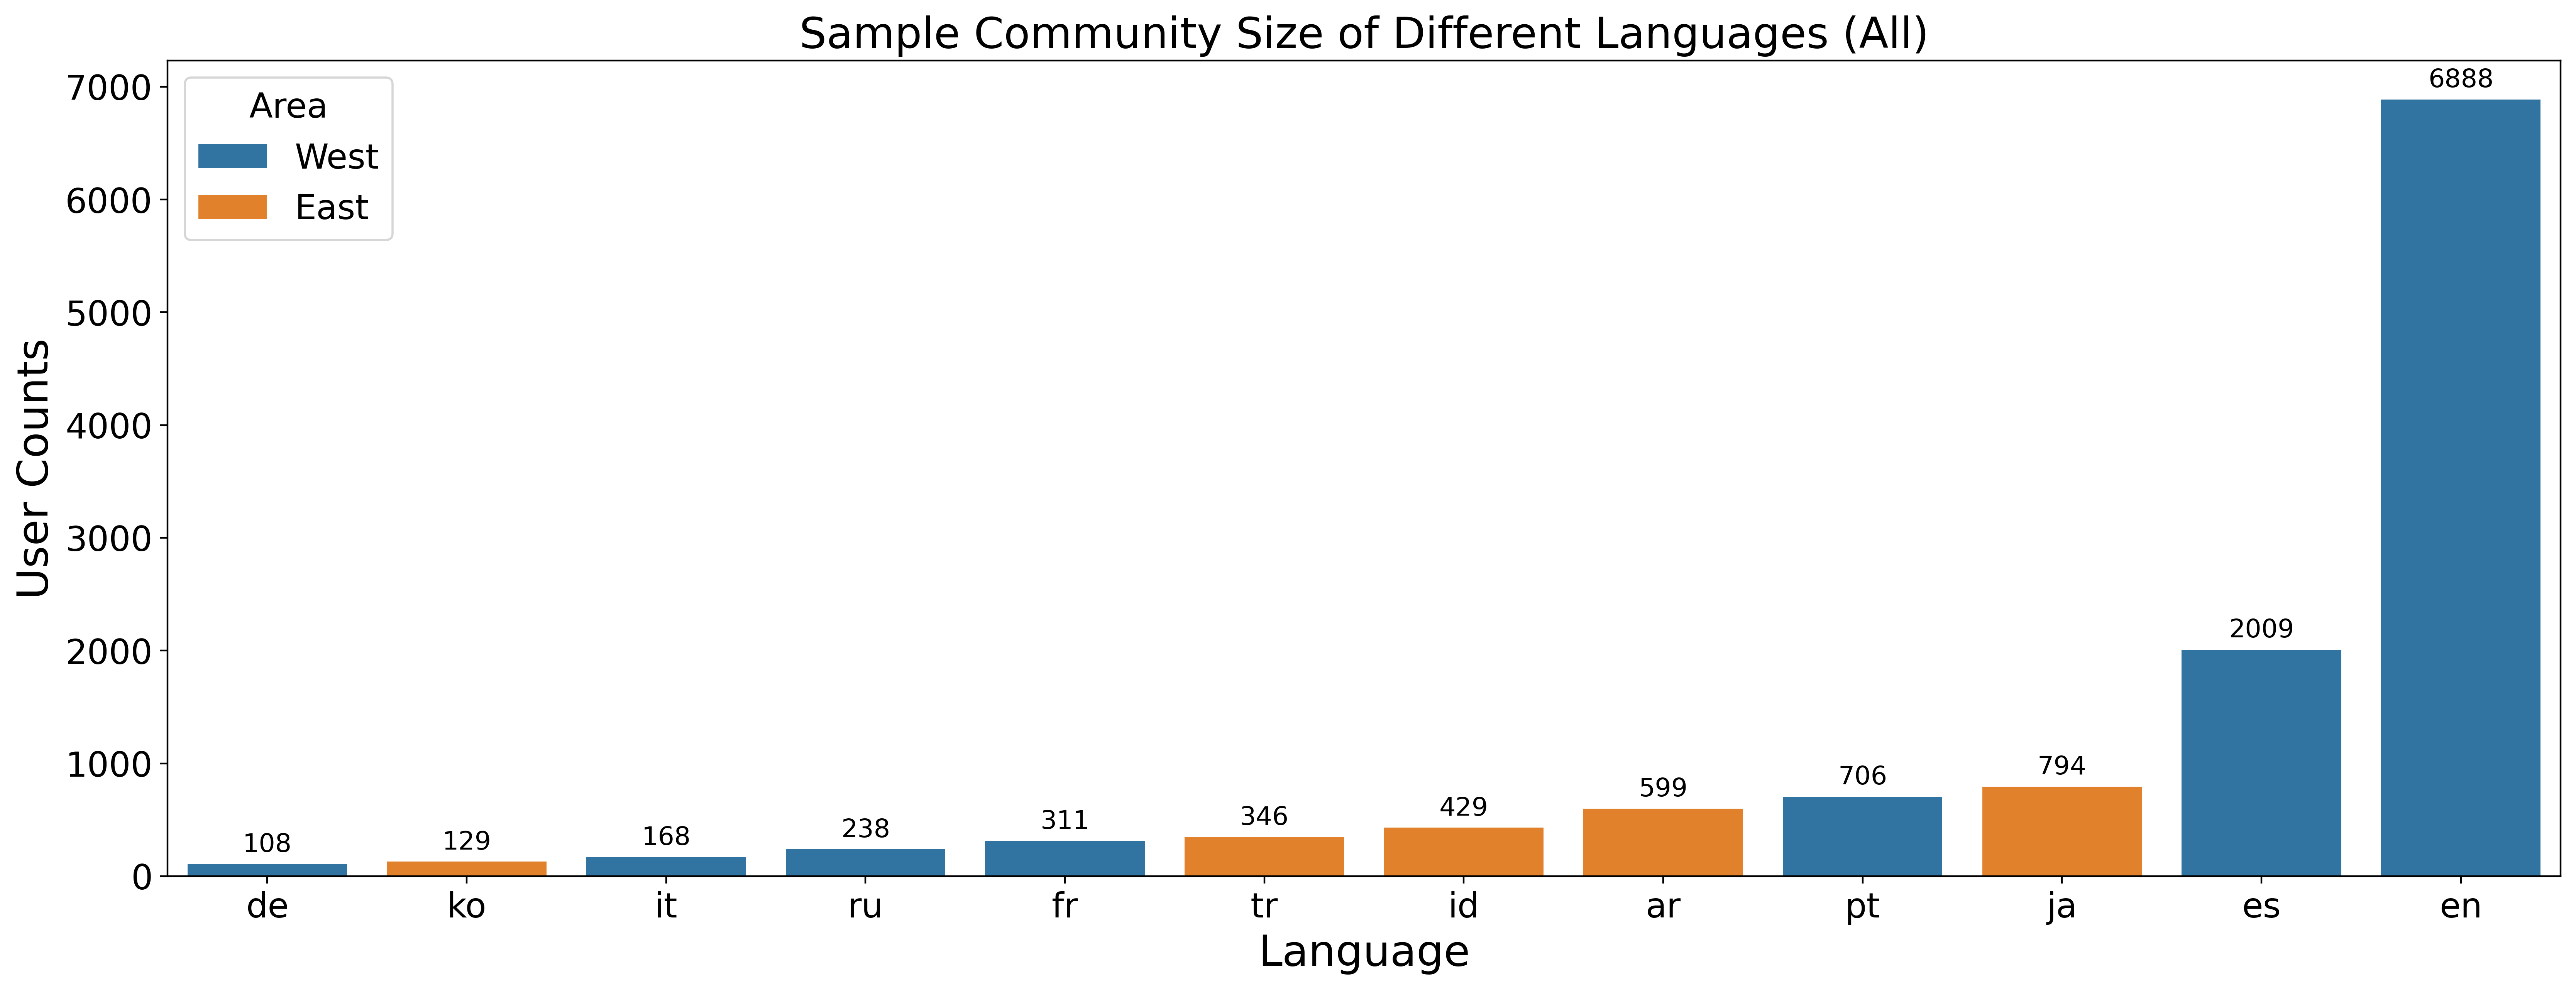

In [18]:
# Set up the plot for ALL LANGUAGES
fig, ax = plt.subplots(figsize = (20, 7), dpi = 400)

# Set up plot parameters
splot = sns.barplot(x = languages_stat.index, y = languages_stat['user_count'], hue = languages_stat['area'], ax = ax,
           dodge = False)
ax.set_xlabel('Language', fontsize = 20)
ax.set_ylabel('User Counts', fontsize = 20)
ax.set_title('Sample Community Size of Different Languages (All)', fontsize=20)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
plt.legend(title="Area", fontsize=16, title_fontsize=16)

# Annotate values for each bar
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points',
                   fontsize = 12) 
#plt.savefig('img/community_size_all.jpg')

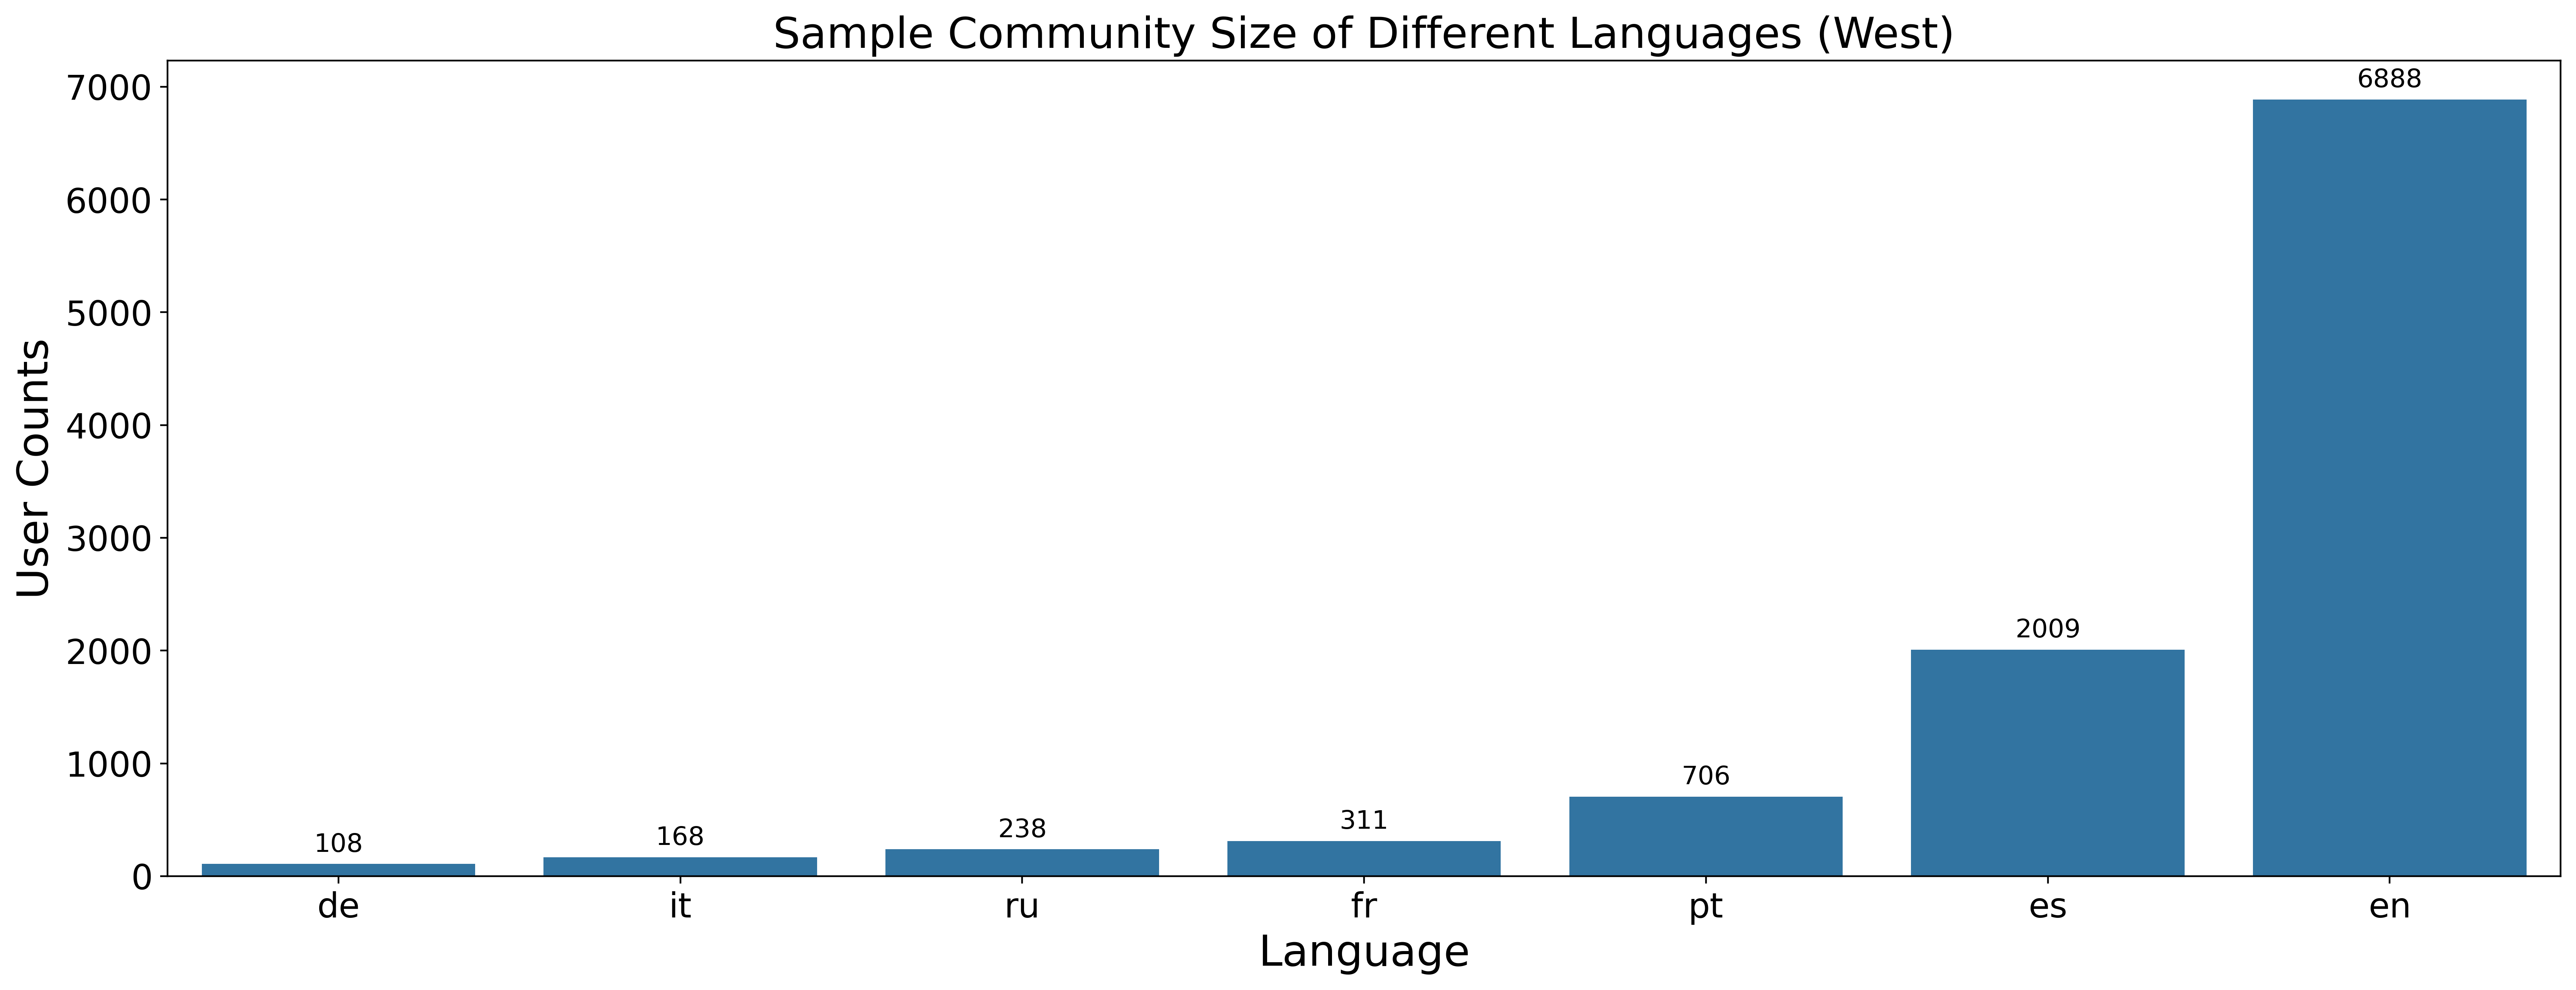

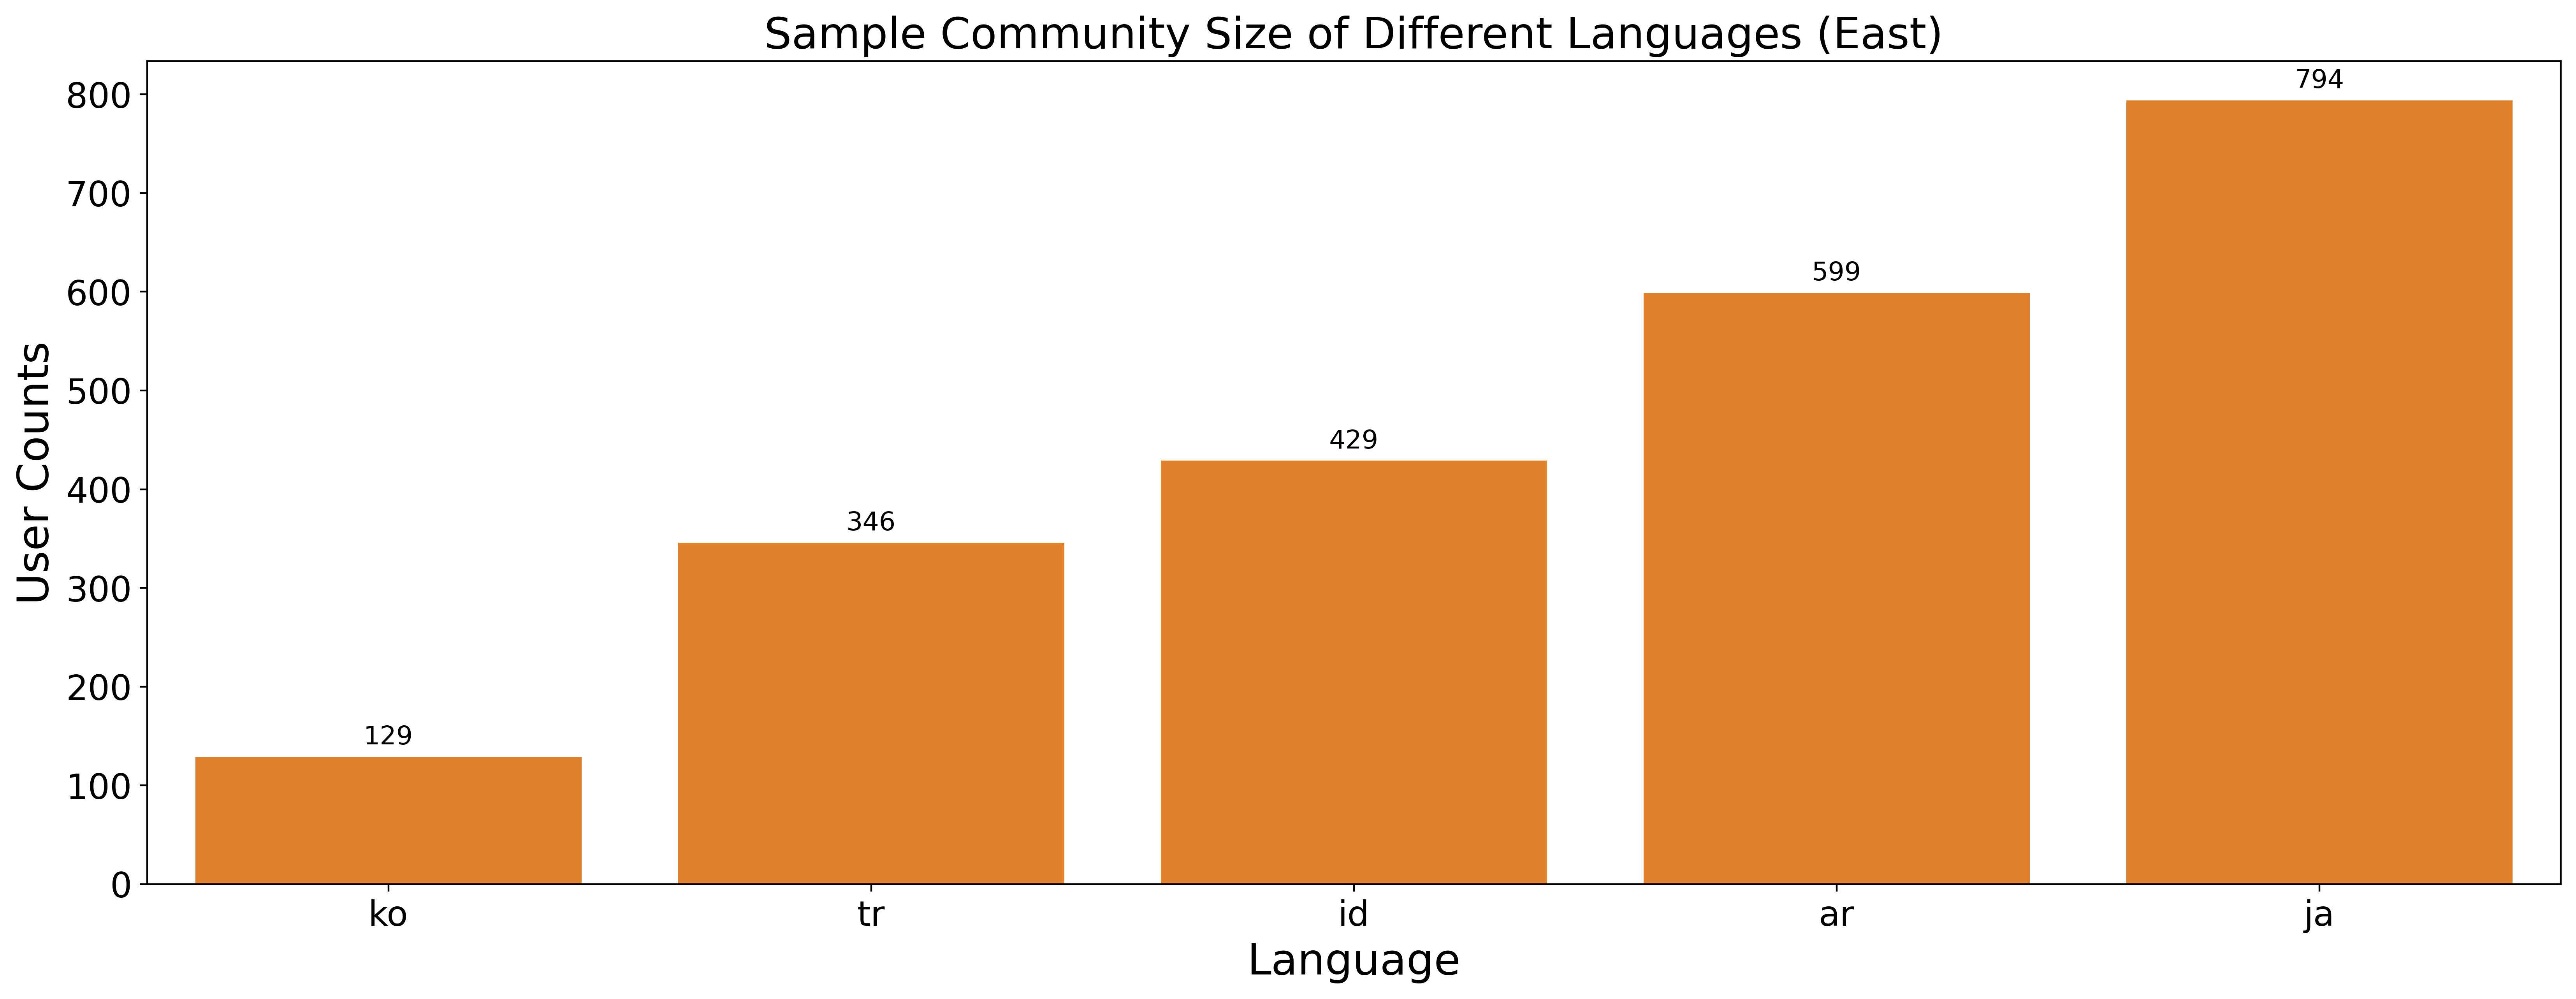

In [19]:
# Set up the plot for the WESTERN LANGUAGES
fig, ax = plt.subplots(figsize = (20, 7), dpi = 400)
languages_stat_west = languages_stat[languages_stat['area']=='West']

# Set up plot parameters
splot = sns.barplot(x = languages_stat_west.index, y = languages_stat_west['user_count'], 
            color = sns.color_palette()[0], ax = ax, dodge = False)
ax.set_xlabel('Language', fontsize = 20)
ax.set_ylabel('User Counts', fontsize = 20)
ax.set_title('Sample Community Size of Different Languages (West)', fontsize=20)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)

# Annotate values for each bar
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points',
                   fontsize = 12) 
#plt.savefig('img/community_size_west.jpg')

# Set up the plot for the EASTERN LANGUAGES
fig, ax = plt.subplots(figsize = (20, 7), dpi = 400)
languages_stat_east = languages_stat[languages_stat['area']=='East']

# Set up plot parameters
splot = sns.barplot(x = languages_stat_east.index, y = languages_stat_east['user_count'], 
            color = sns.color_palette()[1], ax = ax, dodge = False)
ax.set_xlabel('Language', fontsize = 20)
ax.set_ylabel('User Counts', fontsize = 20)
ax.set_title('Sample Community Size of Different Languages (East)', fontsize=20)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)

# Annotate values for each bar
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points',
                   fontsize = 12,) 
#plt.savefig('img/community_size_east.jpg')

Conclusions, if any: 
1. Top three western languages < en, es, pt > constitute ~75% of the total users. 
2. 7 western vs 5 eastern languages. 10,428 western vs 2,297 eastern users.

#### 2.4.2. Different features' distribution among languages
We box-plot each feature, provided and calculated, for each language (also highlighting western and eastern languages). Through this, we can understand the distribution of these features among different languages. 

##### Box-plotting the features depicting popularity of users:
1. Followers count
2. Friends count
3. Internationality

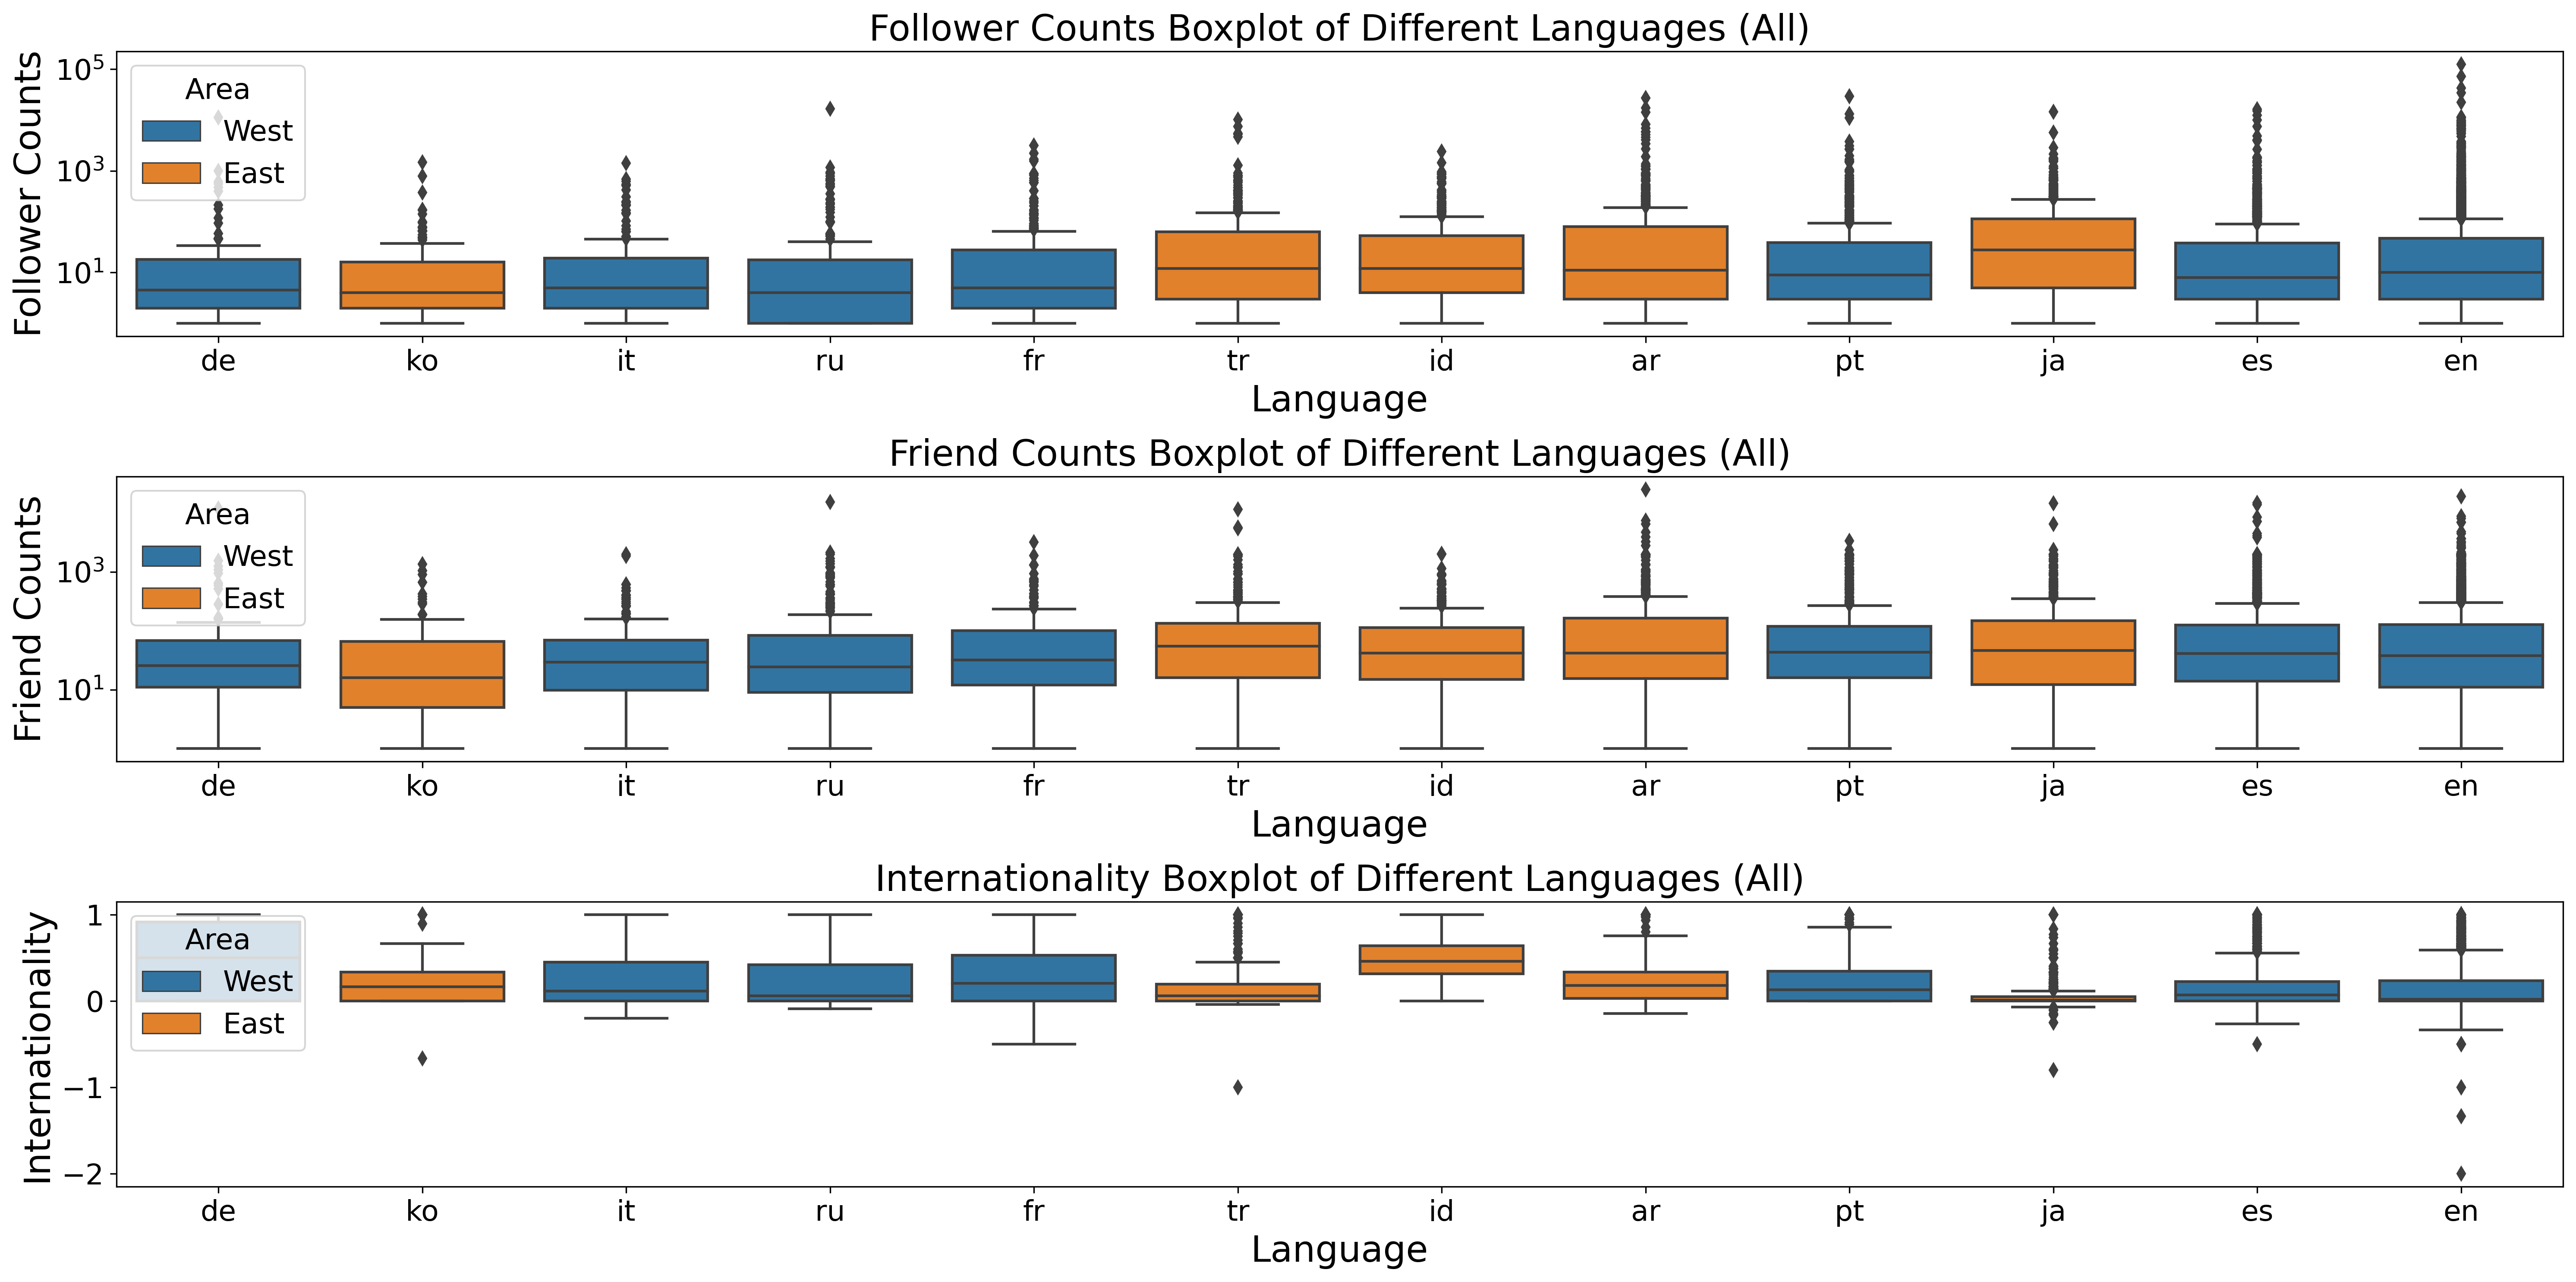

In [20]:
language_order = languages_stat.index.tolist()

# Set up the plot for 'popularity'
fig, ax = plt.subplots(3, 1, figsize = (20, 10), dpi = 300)

ax[0].set(yscale="log")
sns.boxplot(x = 'lang', y = 'followers_count', data = languages, order = language_order, ax = ax[0],
           hue = 'area', dodge = False)
ax[0].set_xlabel('Language', fontsize = 20)
ax[0].set_ylabel('Follower Counts', fontsize = 20)
ax[0].set_title('Follower Counts Boxplot of Different Languages (All)', fontsize=20)
ax[0].xaxis.set_tick_params(labelsize=16)
ax[0].yaxis.set_tick_params(labelsize=16)
ax[0].legend(title="Area", fontsize=16, title_fontsize=16, loc = 2)

ax[1].set(yscale="log")
sns.boxplot(x = 'lang', y = 'friends_count', data = languages, order = language_order, ax = ax[1],
           hue = 'area', dodge = False)
ax[1].set_xlabel('Language', fontsize = 20)
ax[1].set_ylabel('Friend Counts', fontsize = 20)
ax[1].set_title('Friend Counts Boxplot of Different Languages (All)', fontsize=20)
ax[1].xaxis.set_tick_params(labelsize=16)
ax[1].yaxis.set_tick_params(labelsize=16)
ax[1].legend(title="Area", fontsize=16, title_fontsize=16, loc = 2)

#ax[2].set(yscale="log")
sns.boxplot(x = 'lang', y = 'Internationality', data = languages, order = language_order, ax = ax[2],
           hue = 'area', dodge = False)
ax[2].set_xlabel('Language', fontsize = 20)
ax[2].set_ylabel('Internationality', fontsize = 20)
ax[2].set_title('Internationality Boxplot of Different Languages (All)', fontsize=20)
ax[2].xaxis.set_tick_params(labelsize=16)
ax[2].yaxis.set_tick_params(labelsize=16)
ax[2].legend(title="Area", fontsize=16, title_fontsize=16, loc = 2)

fig.tight_layout()
#plt.savefig("img/popularity_statistics_boxplot.jpg")

##### Box-plotting the features depicting activeness of users:
1. Total number of tweets
2. Average daily number of tweets
3. Lateness of subscription

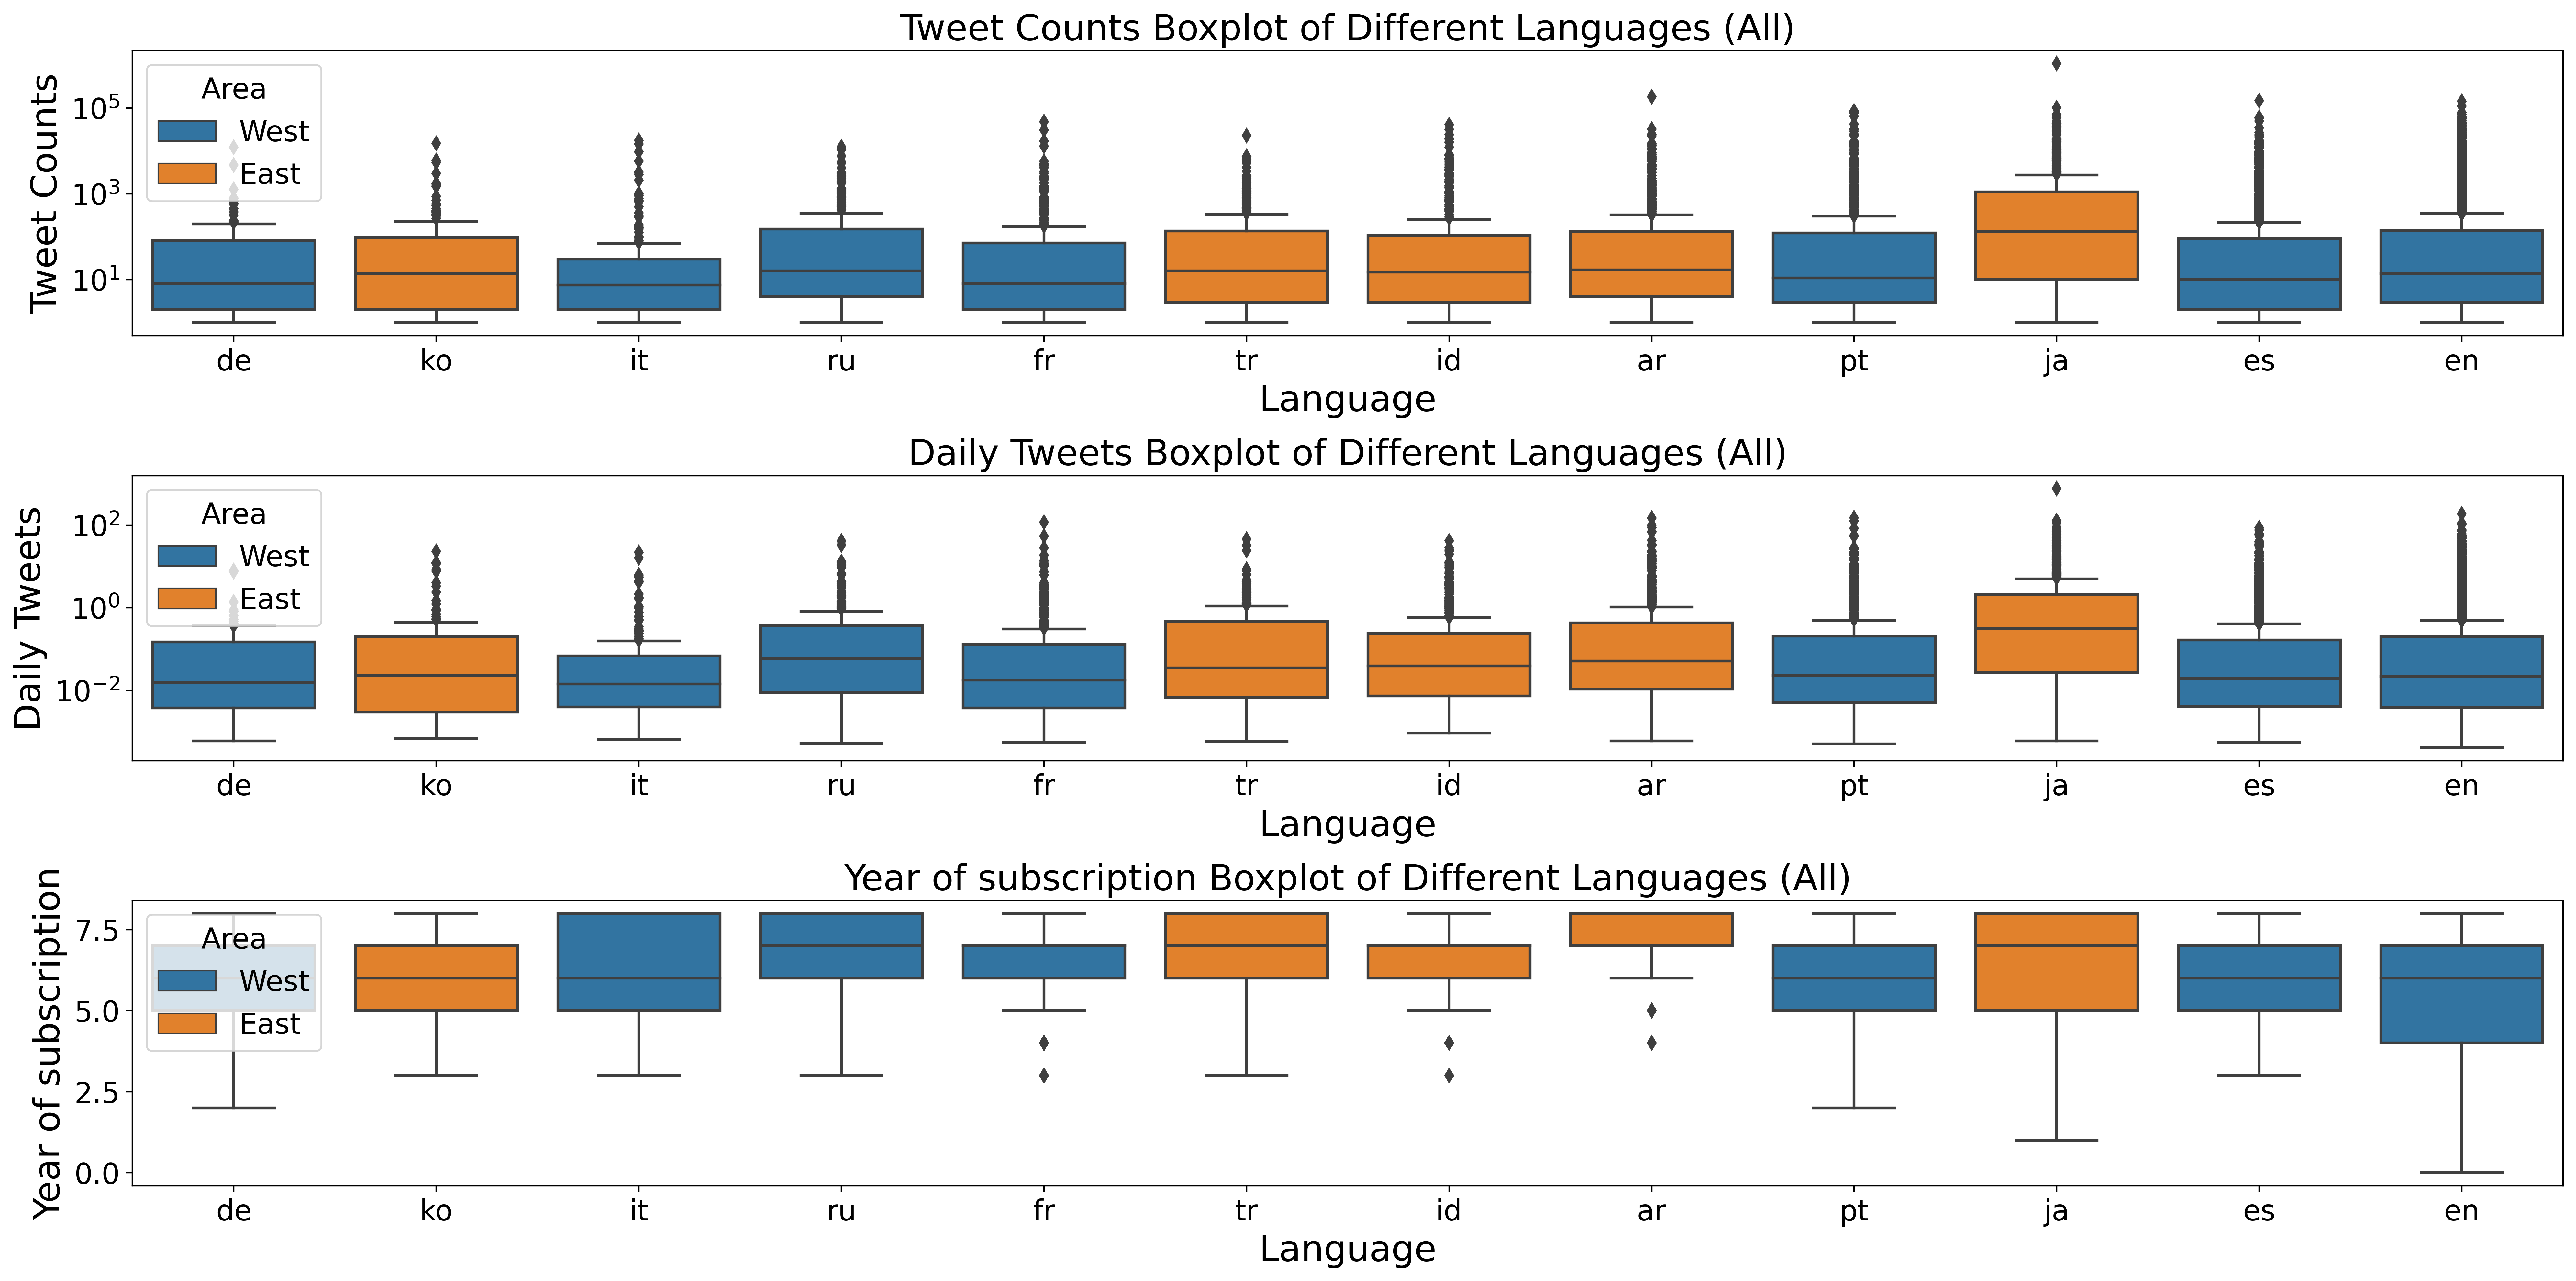

In [21]:
# Set up the plot for 'activness'
fig, ax = plt.subplots(3, 1, figsize = (20, 10), dpi = 400)

ax[0].set(yscale="log")
sns.boxplot(x = 'lang', y = 'statuses_count', data = languages, order = language_order, ax = ax[0],
           hue = 'area', dodge = False)
ax[0].set_xlabel('Language', fontsize = 20)
ax[0].set_ylabel('Tweet Counts', fontsize = 20)
ax[0].set_title('Tweet Counts Boxplot of Different Languages (All)', fontsize=20)
ax[0].xaxis.set_tick_params(labelsize=16)
ax[0].yaxis.set_tick_params(labelsize=16)
ax[0].legend(title="Area", fontsize=16, title_fontsize=16, loc = 2)

ax[1].set(yscale="log")
sns.boxplot(x = 'lang', y = 'avg_daily_tweets', data = languages, order = language_order, ax = ax[1],
           hue = 'area', dodge = False)
ax[1].set_xlabel('Language', fontsize = 20)
ax[1].set_ylabel('Daily Tweets', fontsize = 20)
ax[1].set_title('Daily Tweets Boxplot of Different Languages (All)', fontsize=20)
ax[1].xaxis.set_tick_params(labelsize=16)
ax[1].yaxis.set_tick_params(labelsize=16)
ax[1].legend(title="Area", fontsize=16, title_fontsize=16, loc = 2)

#ax[2].set(yscale="log")
sns.boxplot(x = 'lang', y = 'year', data = languages, order = language_order, ax = ax[2],
           hue = 'area', dodge = False)
ax[2].set_xlabel('Language', fontsize = 20)
ax[2].set_ylabel('Year of subscription', fontsize = 20)
ax[2].set_title('Year of subscription Boxplot of Different Languages (All)', fontsize=20)
ax[2].xaxis.set_tick_params(labelsize=16)
ax[2].yaxis.set_tick_params(labelsize=16)
ax[2].legend(title="Area", fontsize=16, title_fontsize=16, loc = 2)

fig.tight_layout()
#plt.savefig("img/activeness_statistics_boxplot.jpg")

Next, we plot the average values for each feature and observe the trends among different languages (also highlighting western and eastern languages. 

##### Plotting the features depicting popularity of users:
1. Followers count
2. Friends count
3. Internationality

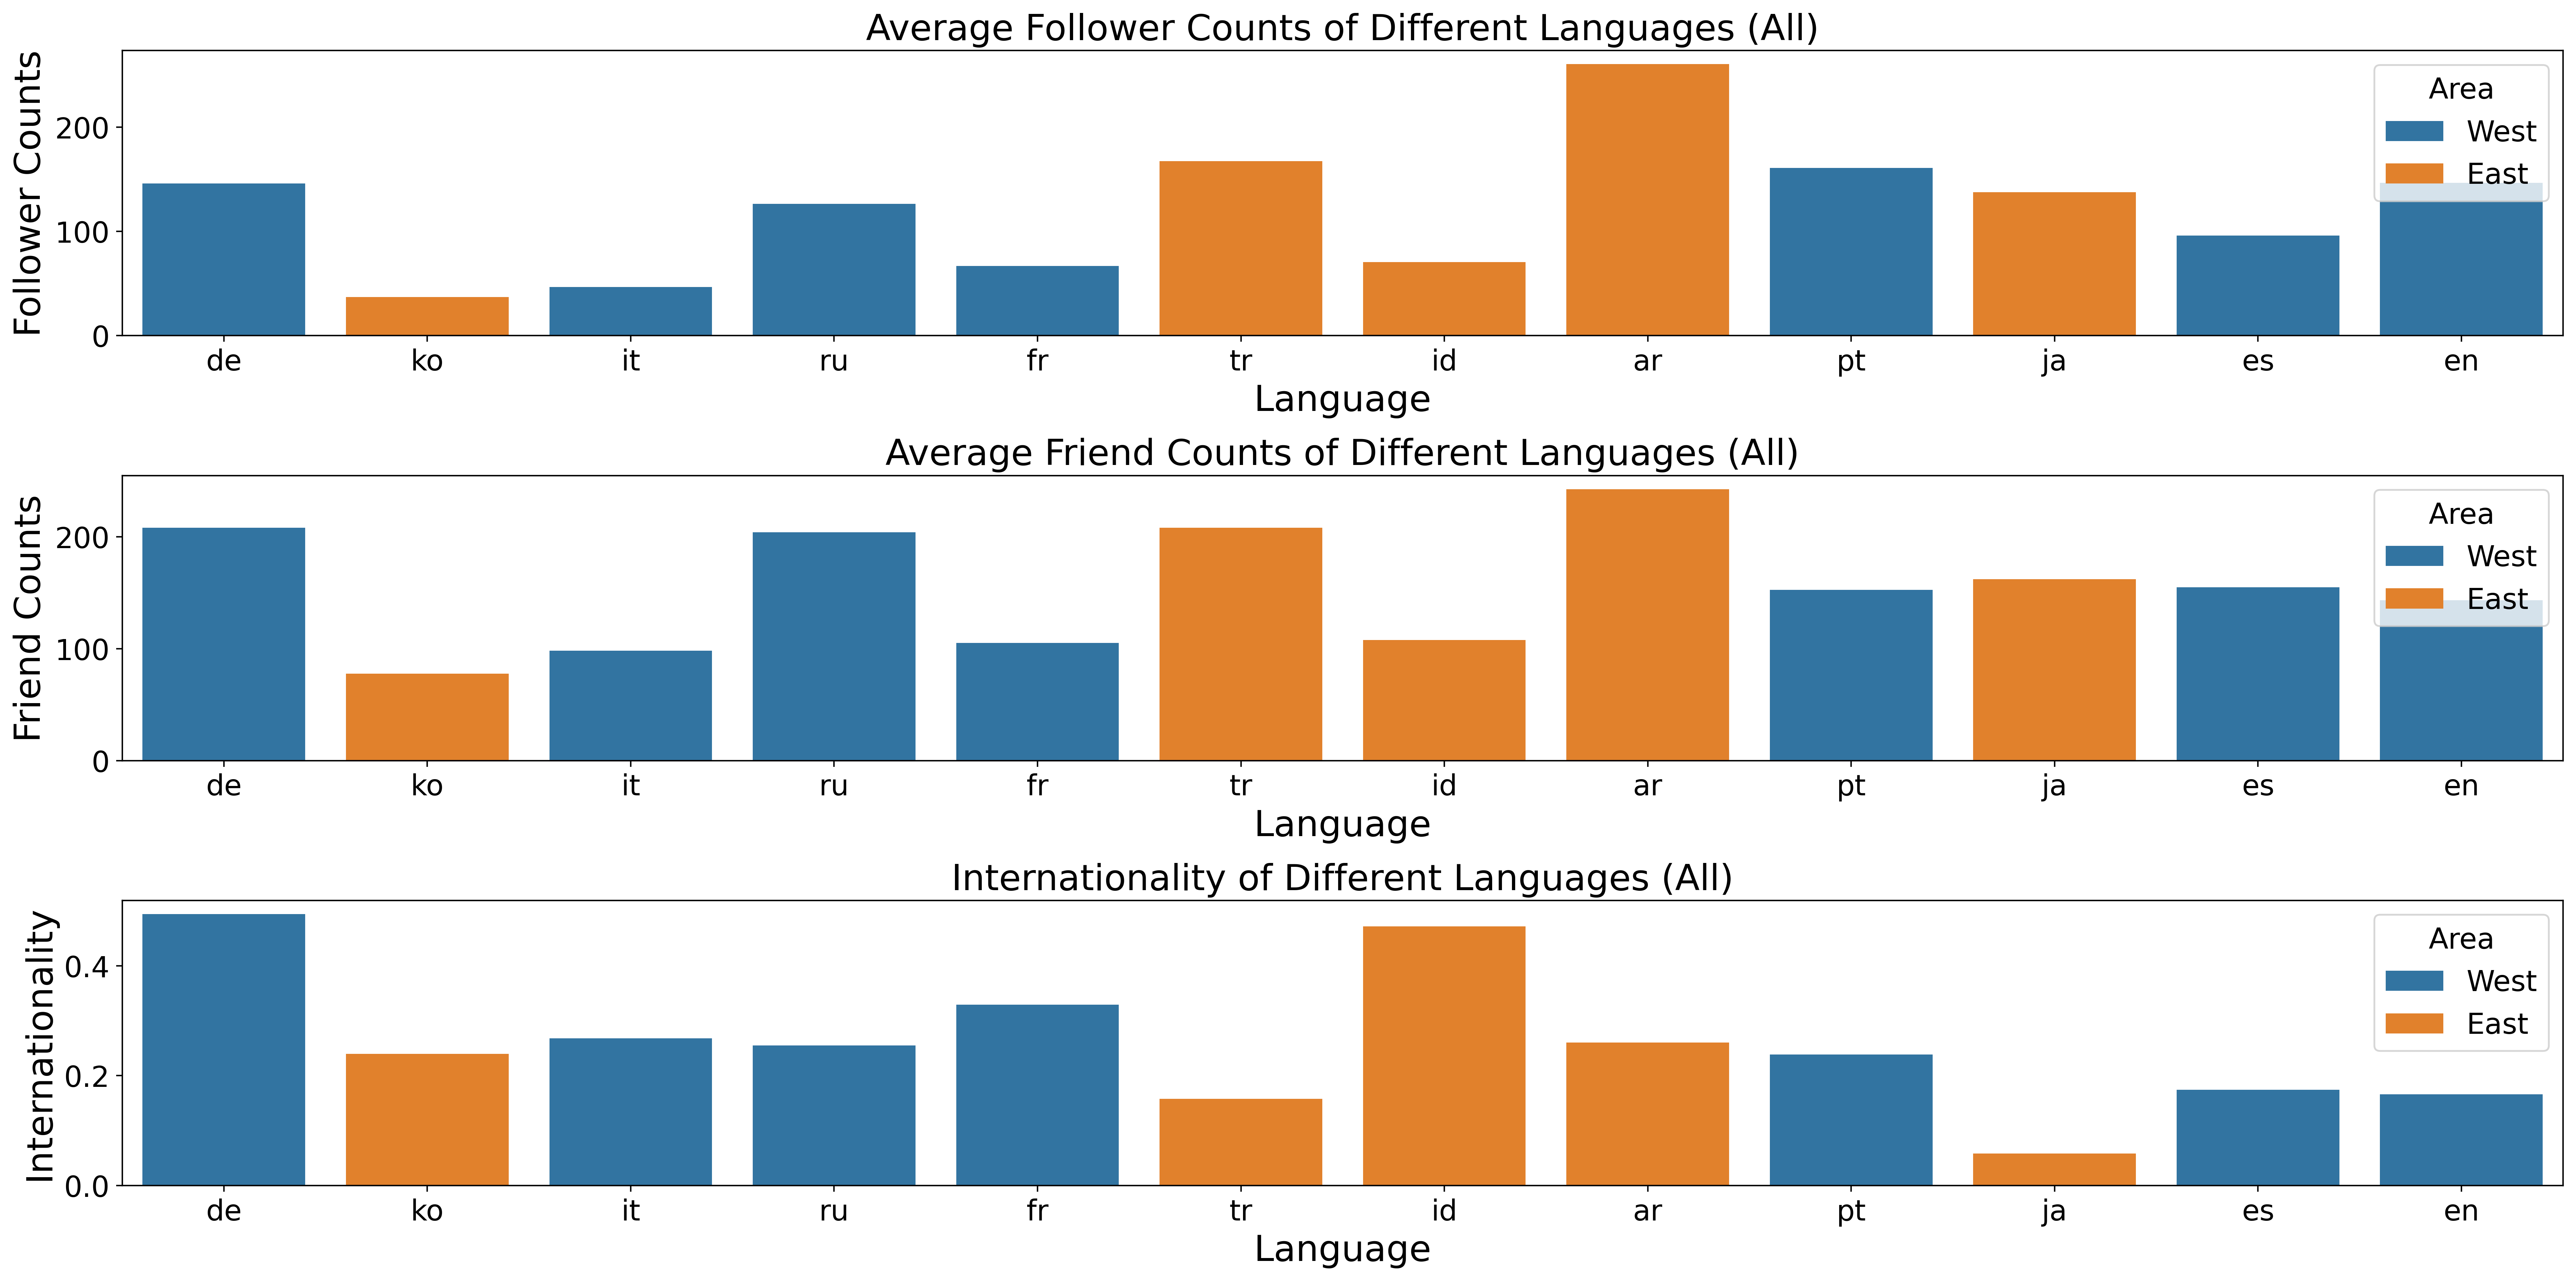

In [22]:
language_order = languages_stat.index.tolist()

# Set up the plot for 'popularity'
fig, ax = plt.subplots(3, 1, figsize = (20, 10), dpi = 400)

#ax[0].set(yscale="log")
sns.barplot(x = languages_stat.index, y = languages_stat['followers_count'], hue = languages_stat['area'], ax = ax[0],
           dodge = False)
ax[0].set_xlabel('Language', fontsize = 20)
ax[0].set_ylabel('Follower Counts', fontsize = 20)
ax[0].set_title('Average Follower Counts of Different Languages (All)', fontsize=20)
ax[0].xaxis.set_tick_params(labelsize=16)
ax[0].yaxis.set_tick_params(labelsize=16)
ax[0].legend(title="Area", fontsize=16, title_fontsize=16, loc = 1)

#ax[1].set(yscale="log")
sns.barplot(x = languages_stat.index, y = languages_stat['friends_count'], hue = languages_stat['area'], ax = ax[1],
           dodge = False)
ax[1].set_xlabel('Language', fontsize = 20)
ax[1].set_ylabel('Friend Counts', fontsize = 20)
ax[1].set_title('Average Friend Counts of Different Languages (All)', fontsize=20)
ax[1].xaxis.set_tick_params(labelsize=16)
ax[1].yaxis.set_tick_params(labelsize=16)
ax[1].legend(title="Area", fontsize=16, title_fontsize=16, loc = 1)

#ax[2].set(yscale="log")
sns.barplot(x = languages_stat.index, y = languages_stat['Internationality'], hue = languages_stat['area'], ax = ax[2],
           dodge = False)
ax[2].set_xlabel('Language', fontsize = 20)
ax[2].set_ylabel('Internationality', fontsize = 20)
ax[2].set_title('Internationality of Different Languages (All)', fontsize=20)
ax[2].xaxis.set_tick_params(labelsize=16)
ax[2].yaxis.set_tick_params(labelsize=16)
ax[2].legend(title="Area", fontsize=16, title_fontsize=16, loc = 1)

fig.tight_layout()
#plt.savefig("img/popularity_statistics_barplot.jpg")

##### Plotting the features depicting the activeness of users:
1. Total number of tweets
2. Average daily number of tweets
3. Lateness of subscription

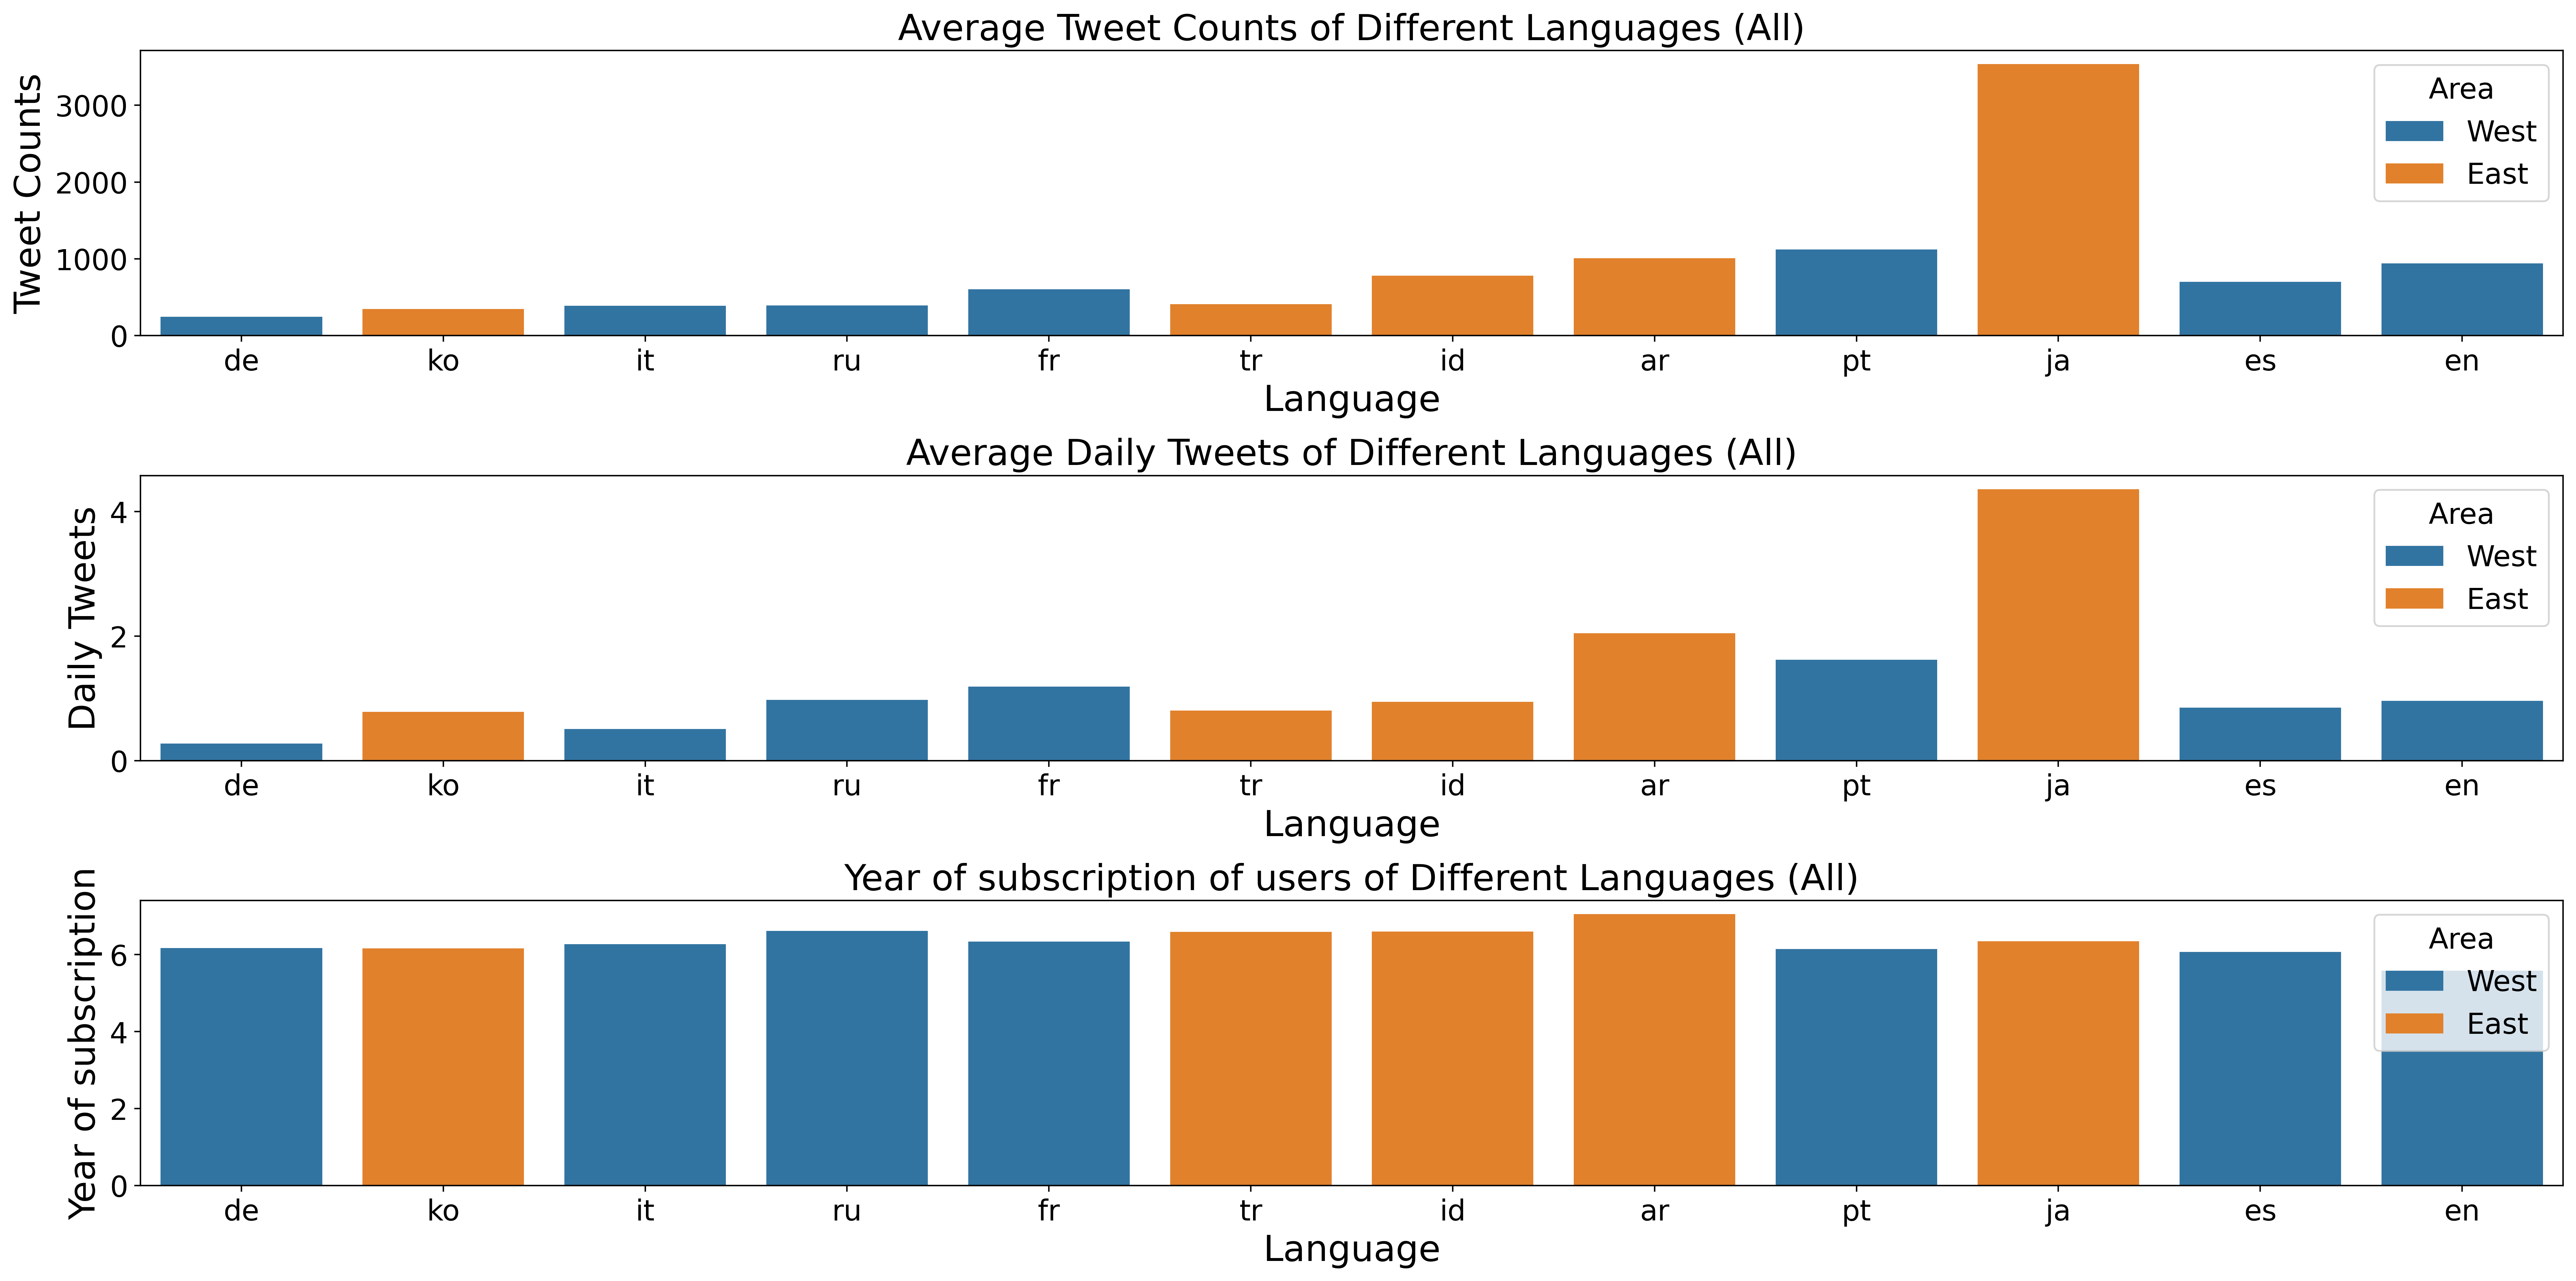

In [23]:
# Set up the plot for 'activeness'
fig, ax = plt.subplots(3, 1, figsize = (20, 10), dpi = 400)

#ax[0].set(yscale="log")
sns.barplot(x = languages_stat.index, y = languages_stat['statuses_count'], hue = languages_stat['area'], ax = ax[0],
           dodge = False)
ax[0].set_xlabel('Language', fontsize = 20)
ax[0].set_ylabel('Tweet Counts', fontsize = 20)
ax[0].set_title('Average Tweet Counts of Different Languages (All)', fontsize=20)
ax[0].xaxis.set_tick_params(labelsize=16)
ax[0].yaxis.set_tick_params(labelsize=16)
ax[0].legend(title="Area", fontsize=16, title_fontsize=16, loc = 1)

#ax[1].set(yscale="log")
sns.barplot(x = languages_stat.index, y = languages_stat['avg_daily_tweets'], hue = languages_stat['area'], ax = ax[1],
           dodge = False)
ax[1].set_xlabel('Language', fontsize = 20)
ax[1].set_ylabel('Daily Tweets', fontsize = 20)
ax[1].set_title('Average Daily Tweets of Different Languages (All)', fontsize=20)
ax[1].xaxis.set_tick_params(labelsize=16)
ax[1].yaxis.set_tick_params(labelsize=16)
ax[1].legend(title="Area", fontsize=16, title_fontsize=16, loc = 1)

#ax[2].set(yscale="log")
sns.barplot(x = languages_stat.index, y = languages_stat['year'], hue = languages_stat['area'], ax = ax[2],
           dodge = False)
ax[2].set_xlabel('Language', fontsize = 20)
ax[2].set_ylabel('Year of subscription', fontsize = 20)
ax[2].set_title('Year of subscription of users of Different Languages (All)', fontsize=20)
ax[2].xaxis.set_tick_params(labelsize=16)
ax[2].yaxis.set_tick_params(labelsize=16)
ax[2].legend(title="Area", fontsize=16, title_fontsize=16, loc = 1)

fig.tight_layout()
#plt.savefig("img/activeness_statistics_barplot.jpg")

Conclusion, if any: 
1. The maximum followers and friends -> ar. They are quite popular online. 
2. The minimum followers and friends -> ko. They tend to have less online presence.
3. The maximum tweets and daily tweets -> ja. They spend a lot of time online. 
2. The minimum tweets and daily tweets -> de. They tend to be less active online. 

For follower and friend counts, the box plots for all languages are approximately quite close. But the 75-100% of the counts vary drastically for some languages. These few number of famous people have an exponentially large number of followers and friends which contributes to a really high count for languages like < en >. 

For the tweets, a clear dominance of the < ja > language is visible. 

#### 2.4.3. Different features' distribution between the two broad cultures
We box-plot each feature, provided and calculated, separately for both the broad cultures - western and eastern languages. Through this, we can understand the unique distribution of these features within each culture. 

This is done to find out if any difference exists between the features plotted for the western and eastern languages.

In [24]:
# Mean values of all features for western and eastern languages 
languages.groupby('area')[['followers_count', 'friends_count', 'statuses_count','avg_daily_tweets']].mean().reset_index()

area  followers_count  friends_count  statuses_count  avg_daily_tweets
0  East       156.053113     175.115803     1712.532434          2.380440
1  West       133.538550     146.302359      867.578730          0.975108

In [25]:
# Median values of all features for western and eastern languages
languages.groupby('area')[['followers_count', 'friends_count', 'statuses_count','avg_daily_tweets']].median().reset_index()

area  followers_count  friends_count  statuses_count  avg_daily_tweets
0  East             15.0             43            29.0          0.078431
1  West              9.0             38            13.0          0.021374

Next, we box-plot each feature and observe the differences between the western and eastern languages. 

##### Plotting the features depicting popularity of users:
1. Followers count
2. Friends count
3. Internationality

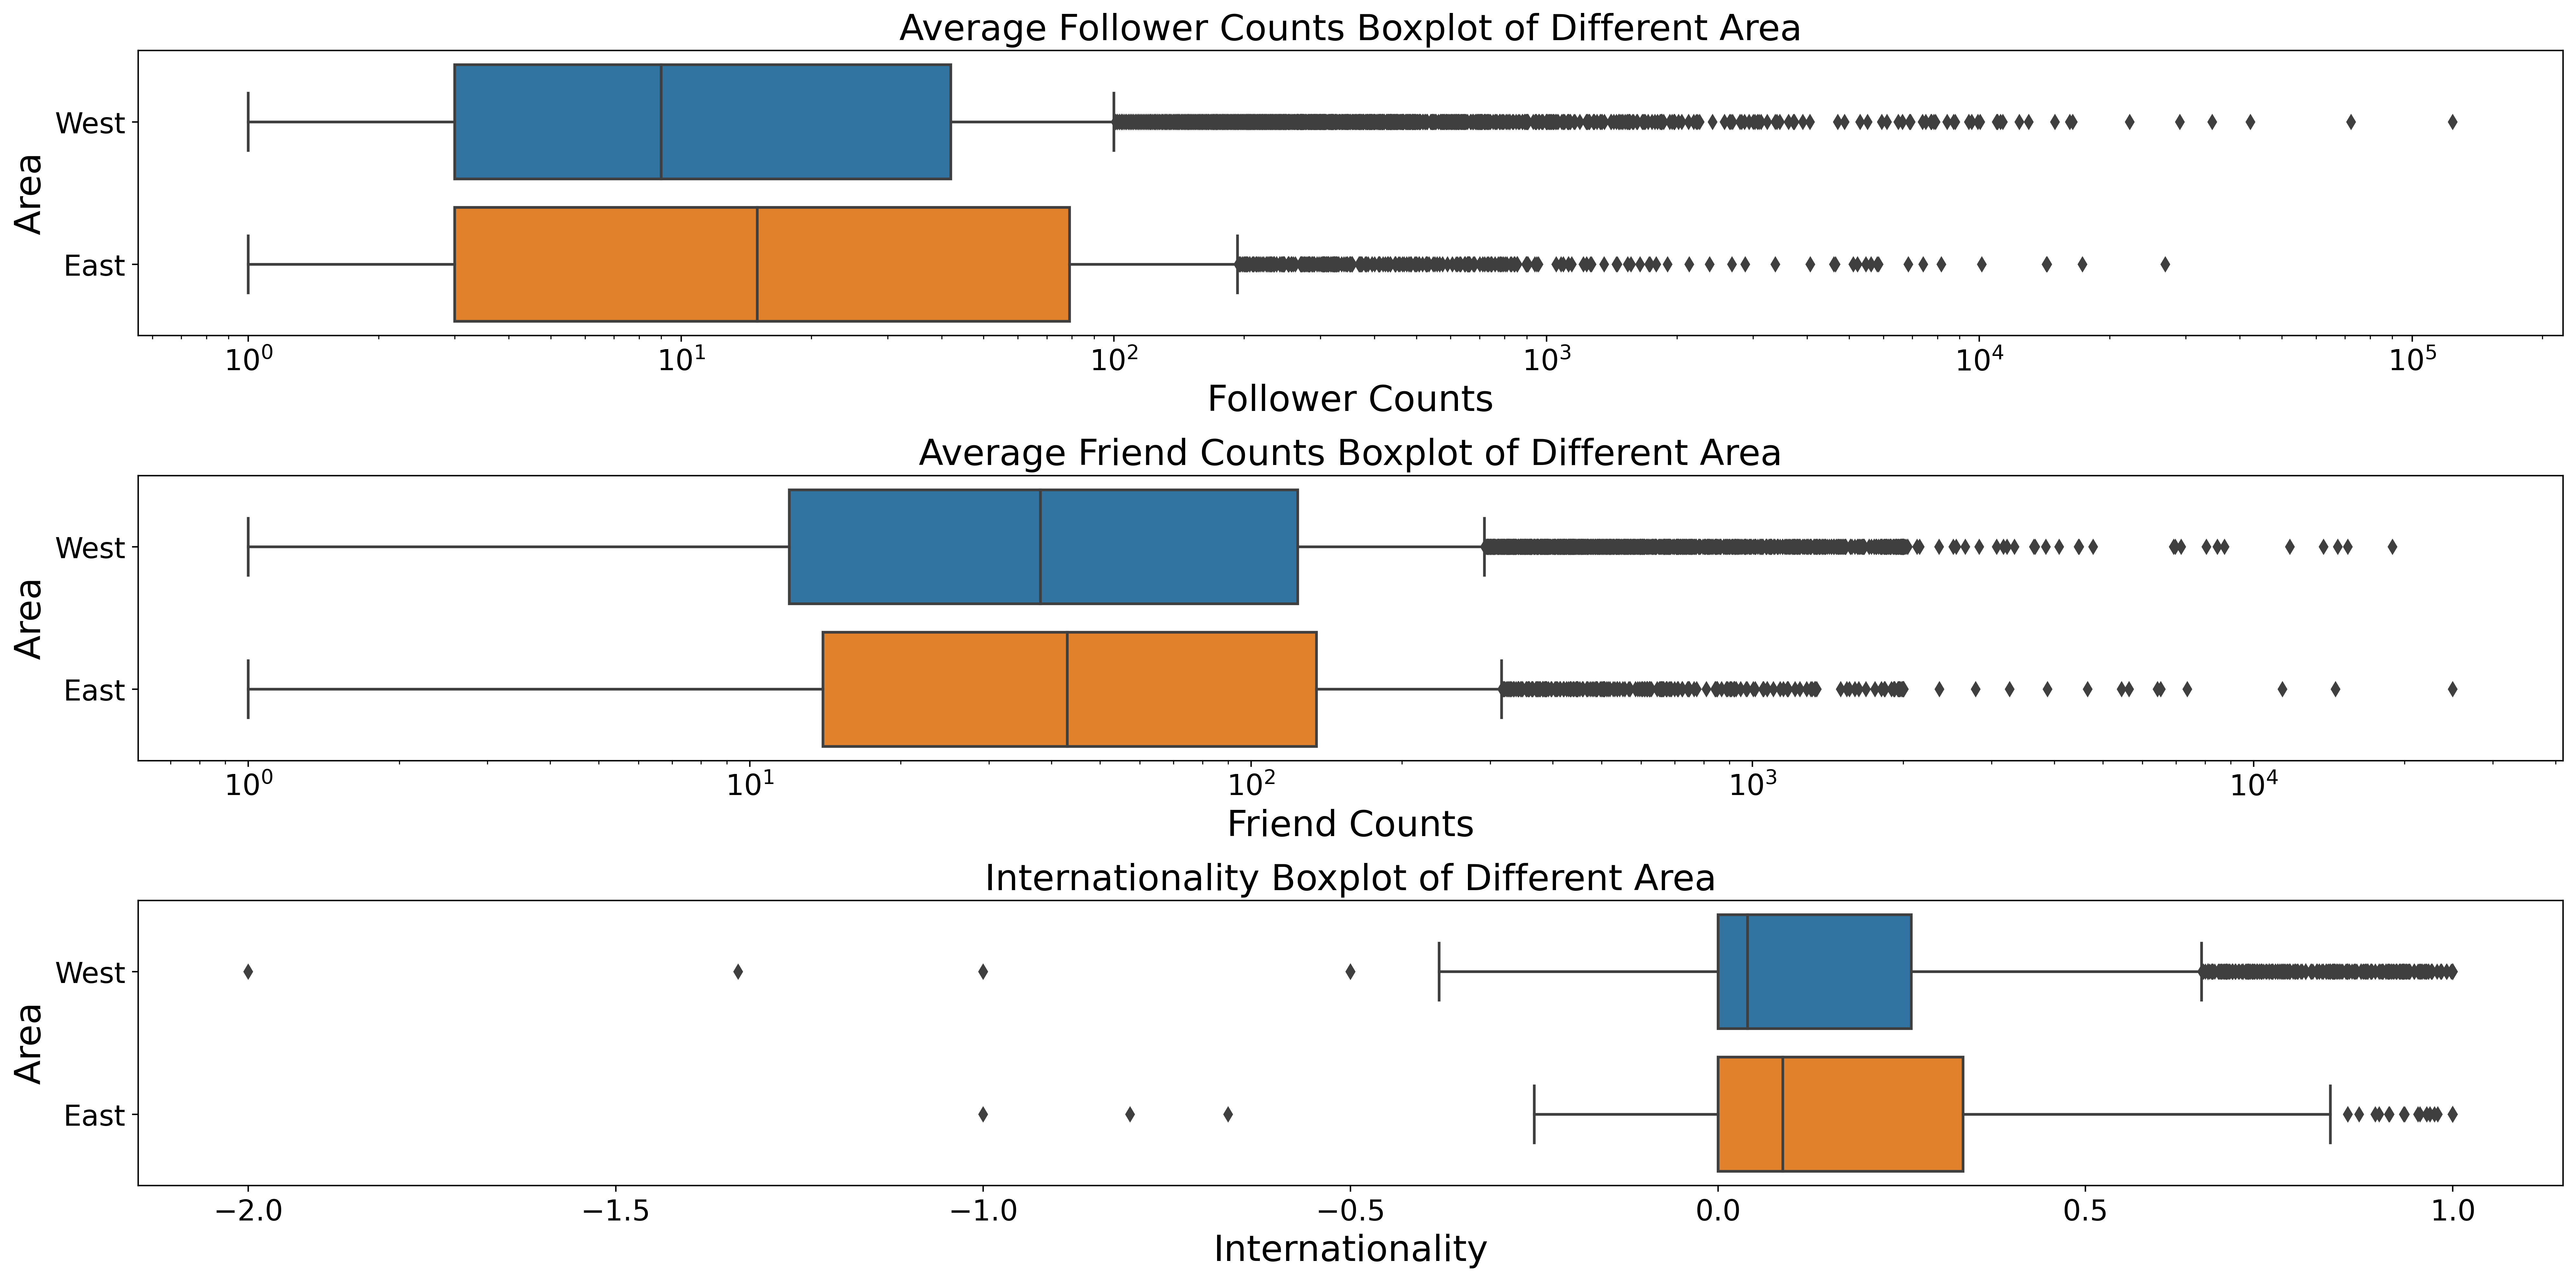

In [26]:
# Set up the plot for 'popularity'
fig, ax = plt.subplots(3, 1, figsize = (20, 10), dpi = 400)

ax[0].set(xscale="log")
sns.boxplot( x = 'followers_count', y = 'area', data = languages, ax = ax[0])
ax[0].set_xlabel('Follower Counts', fontsize = 20)
ax[0].set_ylabel('Area', fontsize = 20)
ax[0].set_title('Average Follower Counts Boxplot of Different Area', fontsize=20)
ax[0].xaxis.set_tick_params(labelsize=16)
ax[0].yaxis.set_tick_params(labelsize=16)

ax[1].set(xscale="log")
sns.boxplot( x = 'friends_count', y = 'area', data = languages, ax = ax[1])
ax[1].set_xlabel('Friend Counts', fontsize = 20)
ax[1].set_ylabel('Area', fontsize = 20)
ax[1].set_title('Average Friend Counts Boxplot of Different Area', fontsize=20)
ax[1].xaxis.set_tick_params(labelsize=16)
ax[1].yaxis.set_tick_params(labelsize=16)

#ax[2].set(xscale="log")
sns.boxplot( x = 'Internationality', y = 'area',  data = languages, ax = ax[2])
ax[2].set_xlabel('Internationality', fontsize = 20)
ax[2].set_ylabel('Area', fontsize = 20)
ax[2].set_title('Internationality Boxplot of Different Area', fontsize=20)
ax[2].xaxis.set_tick_params(labelsize=16)
ax[2].yaxis.set_tick_params(labelsize=16)

fig.tight_layout()
#plt.savefig("img/culture_popularity_boxplot.jpg")

##### Plotting the features depicting activeness of users:
1. Total number of tweets
2. Average daily number of tweets
3. Lateness of subscription

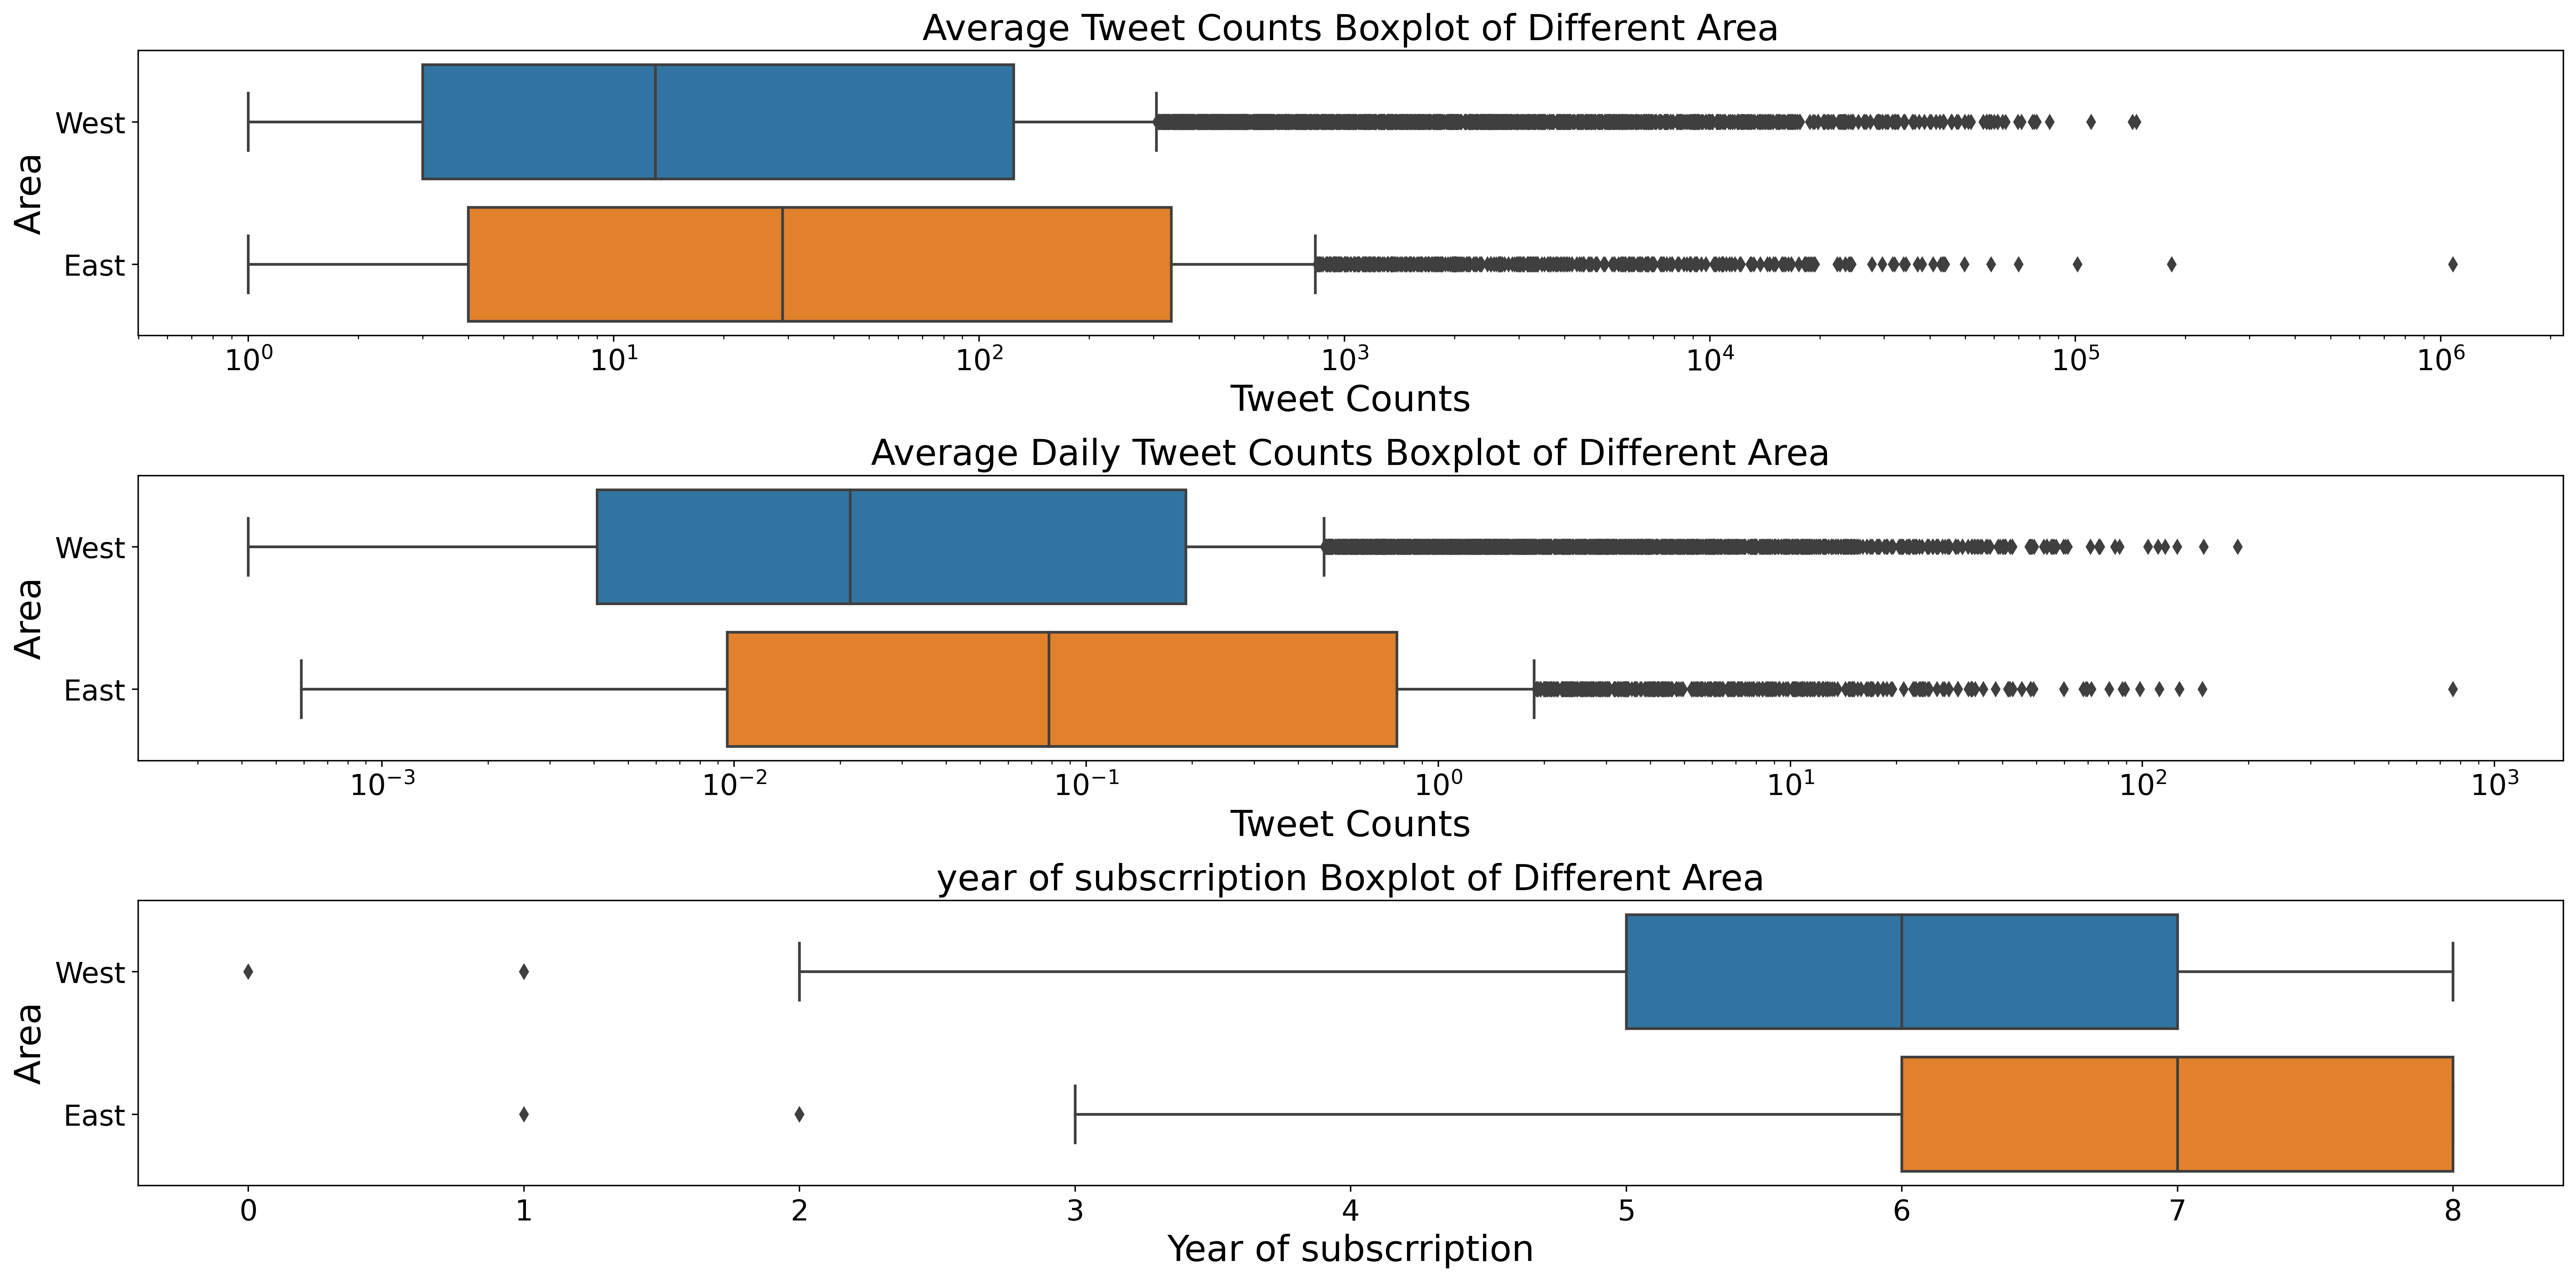

In [27]:
# Set up the plot for 'activeness'
fig, ax = plt.subplots(3, 1, figsize = (20, 10), dpi = 400)

ax[0].set(xscale="log")
sns.boxplot( x = 'statuses_count', y = 'area',  data = languages, ax = ax[0])
ax[0].set_xlabel('Tweet Counts', fontsize = 20)
ax[0].set_ylabel('Area', fontsize = 20)
ax[0].set_title('Average Tweet Counts Boxplot of Different Area', fontsize=20)
ax[0].xaxis.set_tick_params(labelsize=16)
ax[0].yaxis.set_tick_params(labelsize=16)

ax[1].set(xscale="log")
sns.boxplot( x = 'avg_daily_tweets', y = 'area',  data = languages, ax = ax[1])
ax[1].set_xlabel('Tweet Counts', fontsize = 20)
ax[1].set_ylabel('Area', fontsize = 20)
ax[1].set_title('Average Daily Tweet Counts Boxplot of Different Area', fontsize=20)
ax[1].xaxis.set_tick_params(labelsize=16)
ax[1].yaxis.set_tick_params(labelsize=16)

#ax[2].set(xscale="log")
sns.boxplot( x = 'year', y = 'area',  data = languages, ax = ax[2])
ax[2].set_xlabel('Year of subscrription', fontsize = 20)
ax[2].set_ylabel('Area', fontsize = 20)
ax[2].set_title('year of subscrription Boxplot of Different Area', fontsize=20)
ax[2].xaxis.set_tick_params(labelsize=16)
ax[2].yaxis.set_tick_params(labelsize=16)

fig.tight_layout()
#plt.savefig("img/culture_activeness_boxplot.jpg")

There is a more even distribution of followers, friends and tweets in the eastern culture compared to the western culture. 
A larger proportion of counts belong to the top 25% users in the western culture, implying dominance by some famous users. 

For the number of tweets, there is a single point with surprisingly high number of tweets which is very apparent in the boxplot

## 3. Behavior Analysis
To delve deeper into the differences between the western and eastern languages, we try to replicate some figures from the reference paper, except this time, we group the data by `area` (western vs eastern). 

### 3.1. The 80-20 Rule
This rule claims that few active users (20%) created most of the posts (80%) online. It also claims that the online production follows a power law. 

We try to replicate the plots from the reference paper for both the broad cultures. We observe that the distribution of number of tweets per user is quite similar for both western and eastern languages. And the law of 80-20% is still plausible qualitatively. 

In [28]:
# Load the user profiles as DataFrame
user_profiles = pd.read_csv(EGO_PROFILE_PATH, sep = '\t')

In [34]:
# Filter the ego user and sort it by number of tweets
user_profiles = user_profiles[user_profiles['IsEgo'] == True]
ego = user_profiles[user_profiles['IsEgo'] == True]
user_profiles['lang'] = user_profiles['lang'].str.lower()

# Create lists of western and eastern languages
western_language = ['bg', 'ca', 'cs', 'da', 'de', 'el', 'en', 'en-au', 'en-gb', 'es', 'es-mx', 'eu', 'fa',
                 'fi',  'fr', 'he', 'hi', 'hr', 'hu',   'it', 'ka', 'lv', 'nb', 'nl', 'no', 'pl', 'pt',
                 'pt-pt', 'ro', 'ru', 'sr', 'sv', 'uk']

eastern_langauge = ['ar', 'az', 'fil', 'id', 'in', 'ja', 'ko', 'ms', 'msa', 'th', 'tr', 'vi' , 'zh', 'zh-cn',
                    'zh-hans', 'zh-hant', 'zh-tw']

# For the western languages
ego_west = user_profiles[user_profiles['lang'].isin(western_language)]
ego_west = ego_west.sort_values(by = ['statuses_count'], ascending = False).reset_index(drop=True)
# For the eastern languages
ego_east = user_profiles[user_profiles['lang'].isin(eastern_language)]
ego_east = ego_east.sort_values(by = ['statuses_count'], ascending = False).reset_index(drop=True)

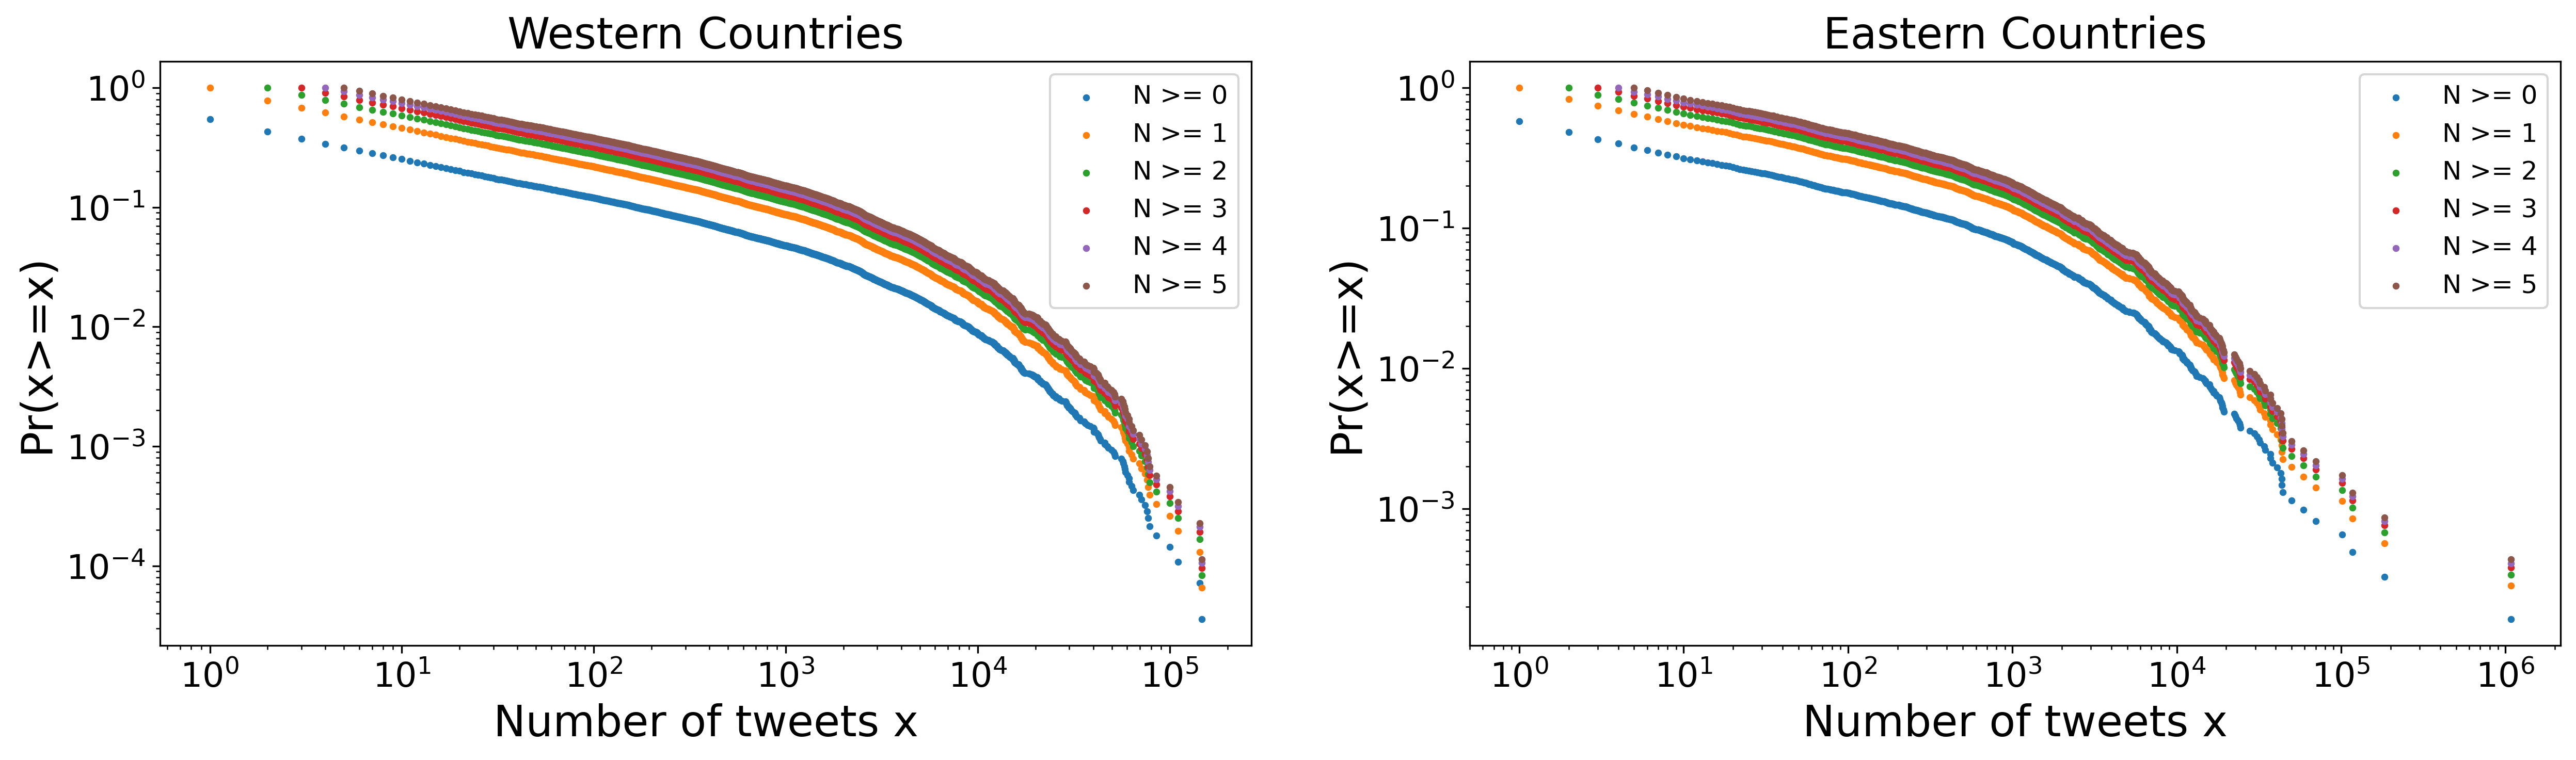

In [30]:
# Set up the plot
fig, ax = plt.subplots(1, 2, figsize = (20, 5), dpi = 300)

# For the western languages
ax[0].set_title('Western Countries', fontsize = 20)
ax[0].set_xlabel('Number of tweets x', fontsize=20)
ax[0].set_ylabel('Pr(x>=x)', fontsize=20)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].xaxis.set_tick_params(labelsize=16)
ax[0].yaxis.set_tick_params(labelsize=16)

# Calculate the number of people for each tweet counts 
temp = ego_west.groupby(ego_west['statuses_count']).count()['ID']
temp = temp.sort_index(ascending = False)

# Loop the threshold from 0 to 5
for N in range(0, 6):
    temp = temp[temp.index >= N]
    tweet = temp.index.to_list()
    count = temp.to_list()
    total = np.sum(count)
    
    # Cumulate tweet counts
    for i in range(1, len(tweet)):
        count[i]+=count[i-1]
    
    # Calculate the ccdf for x (divide cumulated tweet counts by total number of tweets)
    for i in range(len(tweet)):
        count[i]/=total
    
    ax[0].scatter(tweet, count, s = 5, label = 'N >= {}'.format(N))

ax[0].legend(title="", fontsize=12, title_fontsize=12, loc = 1)


# For the eastern languages
ax[1].set_title('Eastern Countries', fontsize = 20)
ax[1].set_xlabel('Number of tweets x', fontsize=20)
ax[1].set_ylabel('Pr(x>=x)', fontsize=20)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].xaxis.set_tick_params(labelsize=16)
ax[1].yaxis.set_tick_params(labelsize=16)

# Calculate the number of people for each tweet counts 
temp = ego_east.groupby(ego_east['statuses_count']).count()['ID']
temp = temp.sort_index(ascending = False)

# Loop the threshold from 0 to 5
for N in range(0, 6):
    temp = temp[temp.index >= N]
    tweet = temp.index.to_list()
    count = temp.to_list()
    total = np.sum(count)
    
    # Cumulate tweet counts
    for i in range(1, len(tweet)):
        count[i]+=count[i-1]
    
    # Calculate the ccdf for x (divide cumulated tweet counts by total number of tweets)
    for i in range(len(tweet)):
        count[i]/=total
    
    ax[1].scatter(tweet, count, s = 5, label = 'N >= {}'.format(N))

ax[1].legend(title="", fontsize=12, title_fontsize=12, loc = 1)

#plt.savefig("img/tweets_per_user_distribution.jpg")
plt.show()

### 3.2. Circadian Rhythms
This pattern claims that Twitter usage is similar to the biological circadian cycle, in terms of usage per day and week. Twitter activity seems to rise every morning until evening, drop down back until morning and then repeat. And this trend is weaker and less in volume during the weekends. 

We try to replicate the plots from the reference paper for both the broad cultures. We observe notable difference in the distribution of the plots. The overall pattern of circadian rhythms is followed for both the cultures, but there are changes in repeating patterns.

In [31]:
# Load the ego timelines as Dataframe
ego_timeline = pd.read_csv(EGO_TIMELINE_PATH, sep = '\t', encoding='latin-1')

In [32]:
# Create a new column to save the time as a datetime object
from datetime import datetime, timedelta

def convert_time(s: str):
    '''
    convert twitter time string format to a datetime object
    '''
    new_time = datetime.strptime(s, '%a %b %d %H:%M:%S %z %Y')
    return new_time

ego_timeline['time'] = ego_timeline['created_at'].astype('str').apply(convert_time)

In [35]:
# Calibrate the time by UTC offset

# create a dictionary to map egoID to utc offset
ego['utc_offset'] = ego['utc_offset'].fillna(0)
offset = dict(zip(ego['ID'], ego['utc_offset']))

def get_offset(ID):
    '''
    obtain the utc offset from the dictionary by ID
    '''
    return offset[ID]

def convert_to_timedelta(s):
    '''
    convert float to timedelta datatype
    '''
    return timedelta(seconds = s)

# create a new column which represents the required offset
ego_timeline['utc_offset'] = ego_timeline['egoID'].apply(get_offset)

# add the offset to the time column
ego_timeline['time'] = ego_timeline['time'] + ego_timeline['utc_offset'].apply(convert_to_timedelta)

In [36]:
# Extract week day and hour from the time column to use later
def get_week_day(dt):
    return dt.strftime('%a')

def get_time(dt):
    return int(dt.strftime("%H"))

ego_timeline['week_day'] = ego_timeline['time'].apply(get_week_day)
ego_timeline['hour'] = ego_timeline['time'].apply(get_time)

In [37]:
# Classify the data into western and eastern languages
ego_lang = dict(zip(ego['ID'], ego['lang'].isin(western_language)))

def add_area(id):
    if ego_lang[id]:
        return 'west'
    else:
        return 'east'

ego_timeline['area'] = ego_timeline['egoID'].apply(add_area)
# For western languages
ego_timeline_west = ego_timeline[ego_timeline['area'] == 'west']
# For eastern languages
ego_timeline_east = ego_timeline[ego_timeline['area'] == 'east']

In [38]:
# Create new dataframes for tweet counts and active user counts for the western and eastern languages
tweet_time_west = ego_timeline_west.groupby( [ 'week_day', 'hour'] ).size().reset_index(name = 'count')
user_time_west = ego_timeline_west.groupby( [ 'week_day', 'hour'] )['egoID'].nunique().reset_index(name = 'count')
tweet_time_east = ego_timeline_east.groupby( [ 'week_day', 'hour'] ).size().reset_index(name = 'count')
user_time_east = ego_timeline_east.groupby( [ 'week_day', 'hour'] )['egoID'].nunique().reset_index(name = 'count')

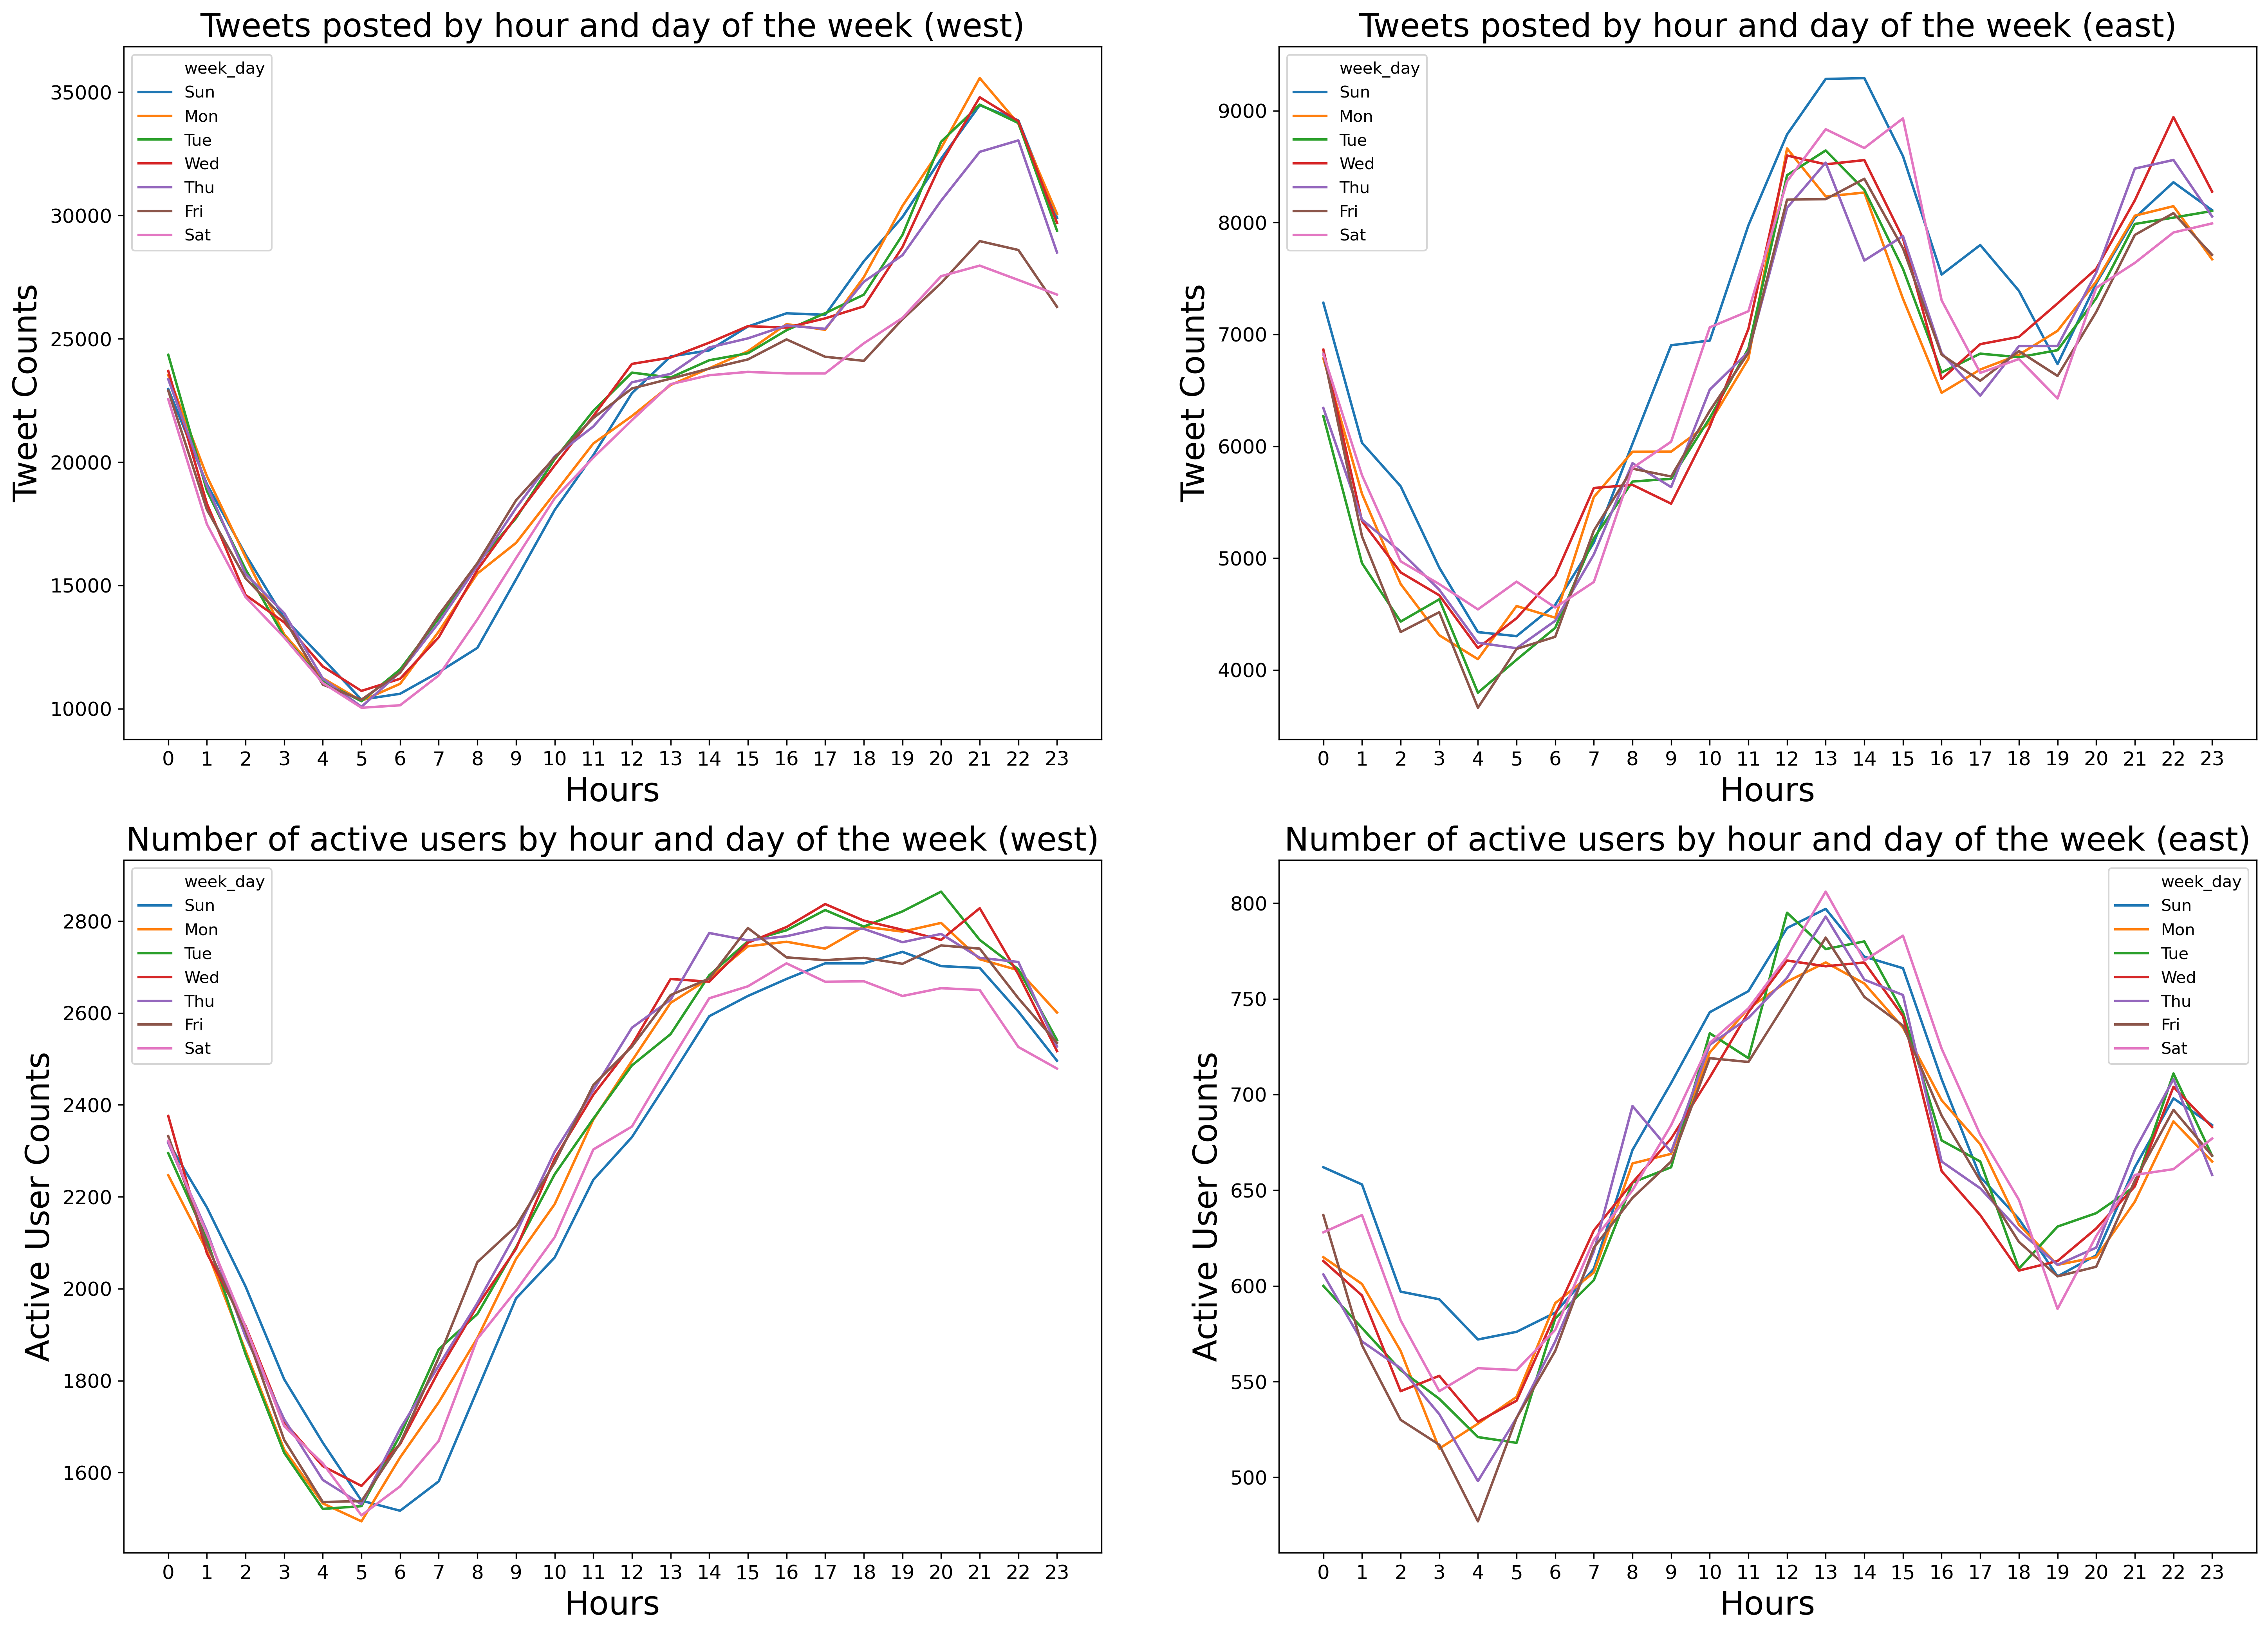

In [39]:
# Set up the plot
fig, ax = plt.subplots(2, 2, figsize = (20, 14), dpi=300)

# For the western languages - number of tweets
sns.lineplot(data = tweet_time_west, x = 'hour', y = 'count', hue = 'week_day', ax = ax[0,0],
             hue_order = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
ax[0,0].set_xlabel('Hours', fontsize=20)
ax[0,0].set_ylabel('Tweet Counts', fontsize=20)
ax[0,0].set_xticks(np.arange(0, 24))
ax[0,0].set_title('Tweets posted by hour and day of the week (west)', fontsize=20)
ax[0,0].xaxis.set_tick_params(labelsize=12)
ax[0,0].yaxis.set_tick_params(labelsize=12)
# For the western languages - number of active users
sns.lineplot(data = user_time_west, x = 'hour', y = 'count', hue = 'week_day', ax = ax[1,0],
            hue_order = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
ax[1,0].set_xlabel('Hours', fontsize=20)
ax[1,0].set_ylabel('Active User Counts', fontsize=20)
ax[1,0].set_xticks(np.arange(0, 24))
ax[1,0].set_title('Number of active users by hour and day of the week (west)', fontsize=20)
ax[1,0].xaxis.set_tick_params(labelsize=12)
ax[1,0].yaxis.set_tick_params(labelsize=12)

# For the eastern languages - number of tweets
sns.lineplot(data = tweet_time_east, x = 'hour', y = 'count', hue = 'week_day', ax = ax[0,1],
             hue_order = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
ax[0,1].set_xlabel('Hours', fontsize=20)
ax[0,1].set_ylabel('Tweet Counts', fontsize=20)
ax[0,1].set_xticks(np.arange(0, 24))
ax[0,1].set_title('Tweets posted by hour and day of the week (east)', fontsize=20)
ax[0,1].xaxis.set_tick_params(labelsize=12)
ax[0,1].yaxis.set_tick_params(labelsize=12)
# For the eastern languages - number of active users
sns.lineplot(data = user_time_east, x = 'hour', y = 'count', hue = 'week_day', ax = ax[1,1],
            hue_order = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
ax[1,1].set_xlabel('Hours', fontsize=20)
ax[1,1].set_ylabel('Active User Counts', fontsize=20)
ax[1,1].set_xticks(np.arange(0, 24))
ax[1,1].set_title('Number of active users by hour and day of the week (east)', fontsize=20)
ax[1,1].xaxis.set_tick_params(labelsize=12)
ax[1,1].yaxis.set_tick_params(labelsize=12)

plt.tight_layout()
#plt.savefig("img/active_time.jpg")
plt.show()

The plot for the eastern and western cultures look quite different. But they still seem to follow the circadian rythm pattern as suggested in the paper. 

But an interesting thing to note is that a peak in the number of tweets is visible around 22h for both west and east, but there is an equally high peak in the number of tweets around 13h in the east. Also, the number of active users gradually increase after 4h for both west and east. But there is a drastic dip in the number of active users between 15h and 21h in the east. The number of tweets is also less during this time in the east.

Also, note the difference in scales. 35k vs 9k tweets per day. 2800 vs 800 active users per day. West vs East. 

### 3.3. Following Preference Analysis

In this section, we would like to know if users in different languages have specific following preference. Therefore we sum up the following relationship between users in different languages, and we could know the following pattern of different language users. Here we only consider the following pairs which egos are the followers.

In [ ]:
ego_network = pd.read_csv(EGO_NETWORK_PATH, sep = '\t')
ego_alter_profiles = pd.read_csv(EGO_PROFILE_PATH, sep = '\t')

In [ ]:
ego_alter_list = languages['ID'].tolist()

#only consider ego as follower
ego_network = ego_network[(ego_network['followerID'].isin(ego_alter_list))]

ego_network.head()

In [ ]:
# assign language to the network dataset
mapping_id_language = dict(zip(ego_alter_profiles['ID'], ego_alter_profiles['lang']))

def assign_lang(id):
    return mapping_id_language[id]

ego_network['lang1'] = ego_network['followerID'].apply(assign_lang)
ego_network['lang2'] = ego_network['followeeID'].apply(assign_lang)
ego_network['same_lang'] = np.where(ego_network['lang1'] == ego_network['lang2'], True, False)

In [ ]:
# Build the following matrix

language_order = languages_stat.index.tolist()
mapping_language = dict(zip(language_order, [i for i in range(0, 12)]))

rows, cols = (12, 12) 
connection = [[0 for i in range(cols)] for j in range(rows)] 
follow_pair = list(zip(ego_network['lang1'], ego_network['lang2']))

# Counting the following pairs
# If one 'ko' follow one 'ja', then matrix['ko']['ja'] add up 1
for i, v in enumerate(follow_pair):
    if follow_pair[i][0] in language_order and follow_pair[i][1] in language_order:
        connection[mapping_language[follow_pair[i][0]]][mapping_language[follow_pair[i][1]]] += 1

connection_dataframe = pd.DataFrame(connection, columns = language_order, index = language_order)  
connection_dataframe.head(12)

In [ ]:
# Setup the plot by the following matrix
for i in range(12):
    fig, ax = plt.subplots(figsize = (20, 7), dpi = 300)
    ax.set(yscale = 'log')
    splot = sns.barplot(x = languages_stat.index, y = connection[i], hue = languages_stat['area'].tolist(),
                        ax = ax, dodge = False)
    ax.set_xlabel('Language', fontsize = 20)
    ax.set_ylabel('Following Counts', fontsize = 20)
    ax.set_title('Total following counts of {} users'.format(languages_stat.index[i]), fontsize=20)
    ax.xaxis.set_tick_params(labelsize=16)
    ax.yaxis.set_tick_params(labelsize=16)
    if i >= 2:
        ax.legend(title="Area", fontsize=16, title_fontsize=16, loc = 2)
    else:
        ax.legend(title="Area", fontsize=16, title_fontsize=16, loc = 0)
    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points',
                   fontsize = 12) 
    #fig.savefig('img/language_following/language_following_counts_{}.jpg'.format(languages_stat.index[i]))

From the figures, we learn that people always like to follow accounts that use same language with themselves. It is obvious. However, we also find other interest facts:

- All users in different languages have a high tendency to follow English accounts.

- Western languages users have higher interest to English accounts that eastern languages users.

- People speak Portuguese and people speak Spanish have higher rate to follow each other comparing to other languages.

In [ ]:
fig, ax = plt.subplots(figsize = (20, 7), dpi=300)

sns.barplot(x = languages_stat.index, y = languages_stat['Internationality'], hue = languages_stat['area'], ax = ax,
           dodge = False)
ax.set_xlabel('Language', fontsize = 20)
ax.set_ylabel('Internationality', fontsize = 20)
ax.set_title('Internationality of Different Languages (All)', fontsize=20)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.legend(title="Area", fontsize=16, title_fontsize=16, loc = 1)

fig.tight_layout()

From the internationality we introduced previously, we could learn that people speak Gernamy have the largest internationality which means they have high interest to follow different languages accounts. On the other hand, people speak Japanese have the lowest internationality, which means they are less likely to follow different languages accounts.

## 4. Culture Prediction

### 4.1. Supervised Learning (Classification of the culture)

### Split the dataset

In [41]:
dataset = languages.drop(columns = ['ID', 'IsEgo', 'lang'])

dataset['area'] = dataset['area'].apply(lambda x: 1 if x=='West' else 0)

train = dataset.sample(frac=0.7,random_state=200)
test = dataset.drop(train.index)

X_train = train.loc[:, train.columns != 'area']
y_train = train['area']
X_test = test.loc[:, test.columns != 'area']
y_test = test['area']

X_train

followers_count  friends_count  statuses_count  Internationality  \
1766              16.0             97             1.0          0.562500   
3008               3.0             77             4.0          0.000000   
12190            286.0            190          2367.0          0.608392   
9362               7.0             18            19.0          0.000000   
4420              23.0             94            60.0          0.521739   
...                ...            ...             ...               ...   
8336              23.0            342            19.0          0.521739   
12088             18.0             23            19.0          0.388889   
6693               1.0             38             3.0          1.000000   
6296               1.0             77             7.0          0.000000   
4223             106.0             58          1357.0          0.443396   

       avg_daily_tweets  year  
1766           0.002146     7  
3008           0.005618     6  
12190          9.903766     8  
9362           0.022042     6  
4420           0.064171     6  
...                 ...   ...  
8336           0.026389     6  
12088          0.078189     8  
6693           0.500000     8  
6296           0.006897     6  
4223           1.422432     6  

[8908 rows x 6 columns]

### Preprocessing

In [42]:
from sklearn import preprocessing
import statsmodels.api as sm

# Polynomial feature expansion
#poly = preprocessing.PolynomialFeatures(2, include_bias=False)
#X_train = poly.fit_transform(X_train)
#X_test = poly.fit_transform(X_test)

# scalarization
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# intercept
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

### Logistic Model

In [43]:
logit_mod = sm.Logit(y_train, X_train)
logit_res = logit_mod.fit()

print(logit_res.summary())

Optimization terminated successfully.
         Current function value: 0.449012
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   area   No. Observations:                 8908
Model:                          Logit   Df Residuals:                     8901
Method:                           MLE   Df Model:                            6
Date:                Wed, 16 Dec 2020   Pseudo R-squ.:                 0.05345
Time:                        21:38:30   Log-Likelihood:                -3999.8
converged:                       True   LL-Null:                       -4225.7
Covariance Type:            nonrobust   LLR p-value:                 2.051e-94
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6191      0.030     53.218      0.000       1.559       1.679
x1            -0.0377      0.

As expected there are regressors more significant then others. In particular there is not strong statical evidence to say that the number of followers ($t-student=-1.091$, $p-value=0.275$) and friends ($t-student=1,003$, $p-value=0.316$) are significant regrossor to predict Western or Eastern culture of a user. Also the number of daily tweets ($t-student=-1.157$, $p-value=0.247$) is not not a significant regressor, but maybe because it is strong correlated with the total number of tweets published and the year of subscription.

In [44]:
from sklearn.metrics import accuracy_score

y_pred = np.around(logit_res.predict(X_train))
print('Accuracy Train: ', accuracy_score(y_train, y_pred))

y_pred = np.around(logit_res.predict(X_test))
print('Accuracy Test: ',accuracy_score(y_test, y_pred))

Accuracy Train:  0.8180287382128424
Accuracy Test:  0.8208016767094577


### Random Forest

In [45]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 500, random_state = 42)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, random_state=42)

In [46]:
from sklearn.metrics import accuracy_score

y_pred = np.around(rf.predict(X_train))
print('Accuracy Train: ', accuracy_score(y_train, y_pred))

y_pred = np.around(rf.predict(X_test))
print('Accuracy Test: ',accuracy_score(y_test, y_pred))

Accuracy Train:  1.0
Accuracy Test:  0.8147760020958869


### 4.2 Usupervised Learning

I would like to get the same cluster of the culture

Text(0.5, 1.0, 'Discovered clusters (PCA)')

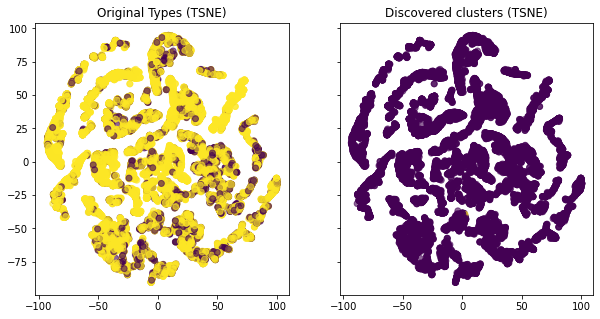

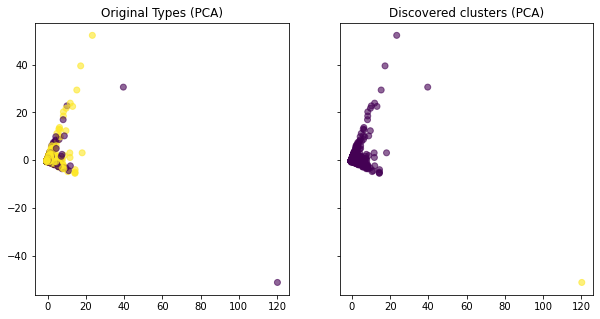

In [47]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

X = dataset.loc[:, dataset.columns != 'area']
y = dataset['area']
X = preprocessing.StandardScaler().fit(X).transform(X)

X_reduced_tsne = TSNE(n_components=2, random_state=0).fit_transform(X)
X_reduced_pca = PCA(n_components=2).fit(X).transform(X)

predicted = KMeans(n_clusters=2, random_state=0).fit_predict(X)

fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True)

axs[0].scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=y, alpha=0.6)
axs[0].set_title("Original Types (TSNE)")

axs[1].scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=predicted, alpha=0.6)
axs[1].set_title("Discovered clusters (TSNE)")

fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True)

axs[0].scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=y, alpha=0.6)
axs[0].set_title("Original Types (PCA)")

axs[1].scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=predicted, alpha=0.6)
axs[1].set_title("Discovered clusters (PCA)")

Text(0.5, 1.0, 'Discovered clusters ')

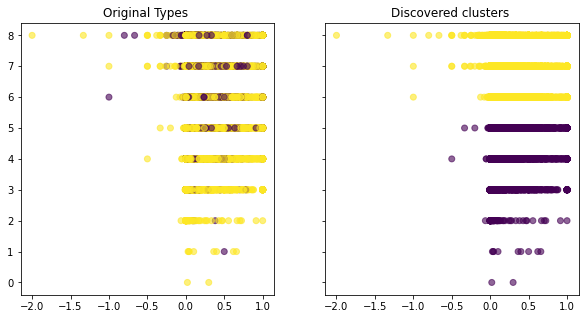

In [48]:
X = dataset[['Internationality','year']]
y = dataset['area']

predicted = KMeans(n_clusters=2, random_state=0).fit_predict(X)

fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True)

axs[0].scatter(X.iloc[:,0], X.iloc[:,1], c=y, alpha=0.6)
axs[0].set_title("Original Types ")

axs[1].scatter(X.iloc[:,0], X.iloc[:,1], c=predicted, alpha=0.6)
axs[1].set_title("Discovered clusters ")

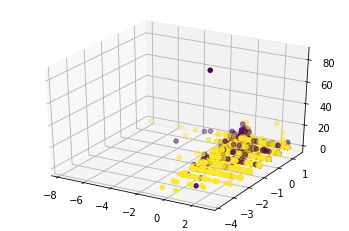

In [49]:
from mpl_toolkits.mplot3d import Axes3D

X = dataset[['Internationality','year','avg_daily_tweets']]
X = preprocessing.StandardScaler().fit(X).transform(X)

ax = plt.axes(projection='3d')
ax.scatter3D(X[:, 0], X[:, 1], X[:, 2], c=y)
#ax.view_init(10, -60)
plt.show()

## 3. Other Unsupersived Learning
no intersting results by now

In [50]:
# Load the ego networks as DataFrame
ego_networks = pd.read_csv("Data/EgoNetworks.txt", sep = '\t')

print(ego_networks)

# Filter out rows with egoID, followerID and followeeID which do not have language information
ego_networks_lang = ego_networks[(ego_networks['egoID'].isin(languages['ID'])) & 
                                (ego_networks['followerID'].isin(languages['ID'])) & 
                                (ego_networks['followeeID'].isin(languages['ID']))]

# Ignore SettingWithCopyWarning - reference: https://www.dataquest.io/blog/settingwithcopywarning/
pd.set_option('mode.chained_assignment', None)

# Create dictionary mapping between users and their languages 
user_lang = dict(zip(languages['ID'], languages['lang']))

# Function to return user language from ID
def get_lang(ID):
    return user_lang[ID]

# Add new column with user languages for followers
ego_networks_lang['follower_lang'] = ego_networks_lang['followerID'].apply(get_lang)
# Add new column with user languages for followees
ego_networks_lang['followee_lang'] = ego_networks_lang['followeeID'].apply(get_lang)

# List of languages
lang_names = ['cs', 'fi', 'sv', 'pl', 'da', 'ru', 'fr', 'ca', 'nl', 'de', 'pt', 'it', 'es', 'en-gb', 'en', 
              'ar', 'id', 'tr', 'zh-tw', 'zh-cn', 'ja', 'th', 'ko', 'fil', 'msa']

# Add new columns for each language for followees
for lang_code in lang_names:
    ego_networks_lang[lang_code] = ego_networks_lang['followee_lang'].apply(lambda x: 1 if x == lang_code else 0)

    
    # Drop the irrelevant columns
ego_networks_lang = ego_networks_lang.drop(columns = ['followerID', 'followeeID', 'follower_lang', 'followee_lang'])
ego_networks_lang.head()

# Create new df, Group by egoID to give the final df
ml_dataset = ego_networks_lang.groupby(['egoID']).sum()
ml_dataset

FileNotFoundError: [Errno 2] File Data/EgoNetworks.txt does not exist: 'Data/EgoNetworks.txt'

In [ ]:
# Load the ego networks as DataFrame
ego_networks = pd.read_csv("Data/EgoNetworks.txt", sep = '\t')
ego_networks

In [ ]:
# Method needs the languages df
languages

In [ ]:
# Filter out rows with egoID, followerID and followeeID which do not have language information
ego_networks_lang = ego_networks[(ego_networks['egoID'].isin(languages['ID'])) & 
                                (ego_networks['followerID'].isin(languages['ID'])) & 
                                (ego_networks['followeeID'].isin(languages['ID']))]

In [ ]:
print("Original ego_networks df had %d rows, but the new ego_networks_lang df has %d rows" 
      %(ego_networks.shape[0], ego_networks_lang.shape[0]))

In [ ]:
# Ignore SettingWithCopyWarning - reference: https://www.dataquest.io/blog/settingwithcopywarning/
pd.set_option('mode.chained_assignment', None)

In [ ]:
# Create dictionary mapping between users and their languages 
user_lang = dict(zip(languages['ID'], languages['lang']))

# Function to return user language from ID
def get_lang(ID):
    return user_lang[ID]

# Add new column with user languages for followers
ego_networks_lang['follower_lang'] = ego_networks_lang['followerID'].apply(get_lang)
# Add new column with user languages for followees
ego_networks_lang['followee_lang'] = ego_networks_lang['followeeID'].apply(get_lang)

In [ ]:
ego_networks_lang.head()

In [ ]:
# List of languages
lang_names = ['cs', 'fi', 'sv', 'pl', 'da', 'ru', 'fr', 'ca', 'nl', 'de', 'pt', 'it', 'es', 'en-gb', 'en', 
              'ar', 'id', 'tr', 'zh-tw', 'zh-cn', 'ja', 'th', 'ko', 'fil', 'msa']

In [ ]:
# Add new columns for each language for followers
#for lang_code in lang_names:
    #ego_networks_lang['follower_lang_' + lang_code] = ego_networks_lang['follower_lang'].apply(lambda x: 1 if x == lang_code else 0)

# Add new columns for each language for followees
for lang_code in lang_names:
    ego_networks_lang['followee_lang_' + lang_code] = ego_networks_lang['followee_lang'].apply(lambda x: 1 if x == lang_code else 0)

In [ ]:
ego_networks_lang.head()

In [ ]:
# Drop the irrelevant columns
ego_networks_lang = ego_networks_lang.drop(columns = ['followerID', 'followeeID', 'follower_lang', 'followee_lang'])
ego_networks_lang.head()

In [ ]:
# Create new df, Group by egoID to give the final df
ml_dataset = ego_networks_lang.groupby(['egoID']).sum()

In [ ]:
ml_dataset = ml_dataset.div(ml_dataset.sum(axis=1), axis=0)

users = list(ml_dataset.index)

In [ ]:
from sklearn.preprocessing import StandardScaler

ml_dataset = StandardScaler().fit(ml_dataset).transform(ml_dataset)

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

X_reduced_tsne = TSNE(n_components=2, random_state=0).fit_transform(ml_dataset)
#X_reduced_pca = PCA(n_components=2).fit(ml_dataset).transform(ml_dataset)

In [ ]:
dict_lang = dict( zip(list(set(languages[ languages['ID'].isin(users) ]['lang'])), list(range(25)) ))
def color_lang(x):
    return dict_lang[x]

In [ ]:
labels_lang = languages[ languages['ID'].isin(users) ]['lang'].apply(lambda x: color_lang(x))
labels_area = languages[ languages['ID'].isin(users) ]['area'].apply(lambda x: 1 if x=='West' else 0)

predicted = KMeans(n_clusters=2, random_state=0).fit_predict(ml_dataset)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

Axes3D.plot(X_reduced_tsne[:,0], X_reduced_tsne[:,1], X_reduced_tsne[:,2], c=labels_area)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

Axes3D.plot(X_reduced_tsne[:,0], X_reduced_tsne[:,1], X_reduced_tsne[:,2], c=predicted)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True)

axs[0].scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=labels_area, alpha=0.6)
axs[0].set_title("Original Types (TSNE)")

axs[1].scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=predicted, alpha=0.6)
axs[1].set_title("Discovered clusters (TSNE)")

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True)

axs[0].scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=labels_lang, alpha=0.6)
axs[0].set_title("Original Types (PCA)")

axs[1].scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=predicted, alpha=0.6)
axs[1].set_title("Discovered clusters (PCA)")

In [ ]:
# List of egoIDs in the dataset
ml_egoIDs = ml_dataset.index.tolist()
print(len(ml_egoIDs))

In [ ]:
ml_dataset.to_csv(r'ml_dataset_1.csv', index = False)